In [8]:
%config InlineBackend.figure_format = 'retina' # For mac users with Retina display
import yaml
import pymc3 as pm
import math
import arviz as az
import theano
import theano.tensor as tensor
import pandas as pd
from matplotlib import rc
from scipy import optimize
import corner as crn
import seaborn as sns
import pickle 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patches as mpl_patches
import pygtc
import json
######
import sys

sys.path.append('../HelpherFunctions/')
from Chi2Allvar import *
from Chi2Lambda import mylikelihoodLambda
from fancyspplot import *
## ***************************************************************************
## * RC param                                                                 *
## ***************************************************************************
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 22
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
## ***************************************************************************
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams['font.family'] = 'monospace'
filename ="../results/data.yaml"
########
stream = open(filename, 'r')#
data = yaml.safe_load(stream)
#
dirc= '/beegfs/desy/user/lalasfar/trilinear4tops'
colpastil = ['#9cadce','#937eba','#f09494','#72bbd0','#52b2cf','#ffafcc','#d3ab9e' ]
NBINS = 100
LambdaNP2 = 1e+3**2
v4 = 246.**4
v3 = 246.**3
mh2 = 125.1**2
sqrt_2 = np.sqrt(2.0)
def mode(x):
    """ Finds the mode of x
        argument:
            x: an array
    """
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def multimode(x, n, hdi_prob):
    """ Finds all the modes in the distribution
        arguments:
            x: the array for the distribution
            n: the identifier for the variable
    """
    md = az.hdi(x, hdi_prob=hdi_prob, multimodal=False)
    if len(md) < 2 and n > 1:
        return np.NaN
    else:
        return md[n%2]
    
def mode(x):
    # Function to find mode of an array x
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def minimize(likelihood, guess):
    """ Minimizing routine for finding global mode
    argument:
        likelihood: the likelihood function
        guess: the guess for the mode, [r, theta]
    """
    res = optimize.minimize(lambda x: -likelihood(x[0], x[1]), guess, method='BFGS', tol=1e-6)
    return res
unity = lambda x : x


def runMCMC1param(likelihood, limits, trace_dir='', config=[], fit=True):
    """ pyMC3 MCMC run
        argument:
            likelihood: the likelihood function
            limits: an array of the limits for the parameters [r_lowers, r_upper, theta_lower, theta_upper]
            trace_dir: the directory to which the MCMC traces are saves. '' implies none
            config: the setup for the MCMC. [MCMC smaple size, target_accept, chains]
            fit: bolean for determining whether to run the fit
        returns:
            trace: if fit is true it returns the trace
            model;if fit is false it returns the model
    """
    with pm.Model() as model:
        k1 = pm.Uniform('k1', lower=limits[0], upper=limits[1])
        like = pm.Potential('like', likelihood(k1))
        
    if fit:
        with model:
       #     theano.config.compute_test_value = "off"
            trace = pm.sample(config[0], tune=int(np.max([1000,config[0]/5])), cores=4, target_accept=config[1], chains=config[2], init='advi_map')
#             print(az.summary(trace, round_to=5)) # Turn on to print summary
       #     theano.config.compute_test_value = "off"
           # if trace_dir != '': pm.save_trace(trace=trace, directory=trace_dir, overwrite=True)
            with open(trace_dir, 'wb') as buff:
                pickle.dump({'model': model, 'trace': trace}, buff)
        return trace, model
    return model

In [9]:
def plotdist(data,data2,filename,label, limit):
    stats_func_2 = {
        'b0': lambda x: multimode(x, 0, 0.9545),
        'b1': lambda x: multimode(x, 1, 0.9545),
        }
    var = ['k1']
    tr =data.get_values('k1', burn=100, combine=True)
    tr2 =data2.get_values('k1', burn=100, combine=True)
    colpastil = ['#9cadce','#937eba','#f09494','#72bbd0', '#ffcaaf' ,'#ffafcc','#d3ab9e' ]
    #fig, ax = plt.subplots(1, figsize=(8, 8))
    df_2 = pd.DataFrame(az.summary(data, kind='stats', hdi_prob=0.9545, round_to='none', stat_funcs=stats_func_2))
    xup=df_2.loc['k1']['hdi_97.725%']
    xmu=[df_2.loc['k1']['mean']]
    xdown=df_2.loc['k1']['hdi_2.275%']
    print('run2')
    print(df_2)
    df_22 = pd.DataFrame(az.summary(data2, kind='stats', hdi_prob=0.9545, round_to='none', stat_funcs=stats_func_2))
    xup2=df_22.loc['k1']['hdi_97.725%']
    xmu2=[df_22.loc['k1']['mean']]
    xdown2=df_22.loc['k1']['hdi_2.275%']
    print('HL-LHC')
    #print(xup2)
    #print(xmu2)
    print(df_22)


    #az.plot_posterior(data, var_names=['k1'], hdi_prob=.95,color=colpastil[2],ax=ax)
    #az.plot_posterior(data, var_names=['k1'], hdi_prob=.95)
    GTC = pygtc.plotGTC(chains=[np.array([tr]).T,np.array([tr2]).T],
                    paramNames=r'label',
                    chainLabels=['LHC Run-II','HL-LHC'],
                    truths=[0.],
                    customLegendFont={'family':'serf', 'size':28},
                    truthLabels='',
                    colorsOrder=['blues_old','reds_old'],
                    figureSize='APJ_page',
                    doOnly1dPlot=True,
                    filledPlots=False)

    for ax in GTC.get_axes():
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='y', which='both', direction='in')
        ax.tick_params(axis='x',  which='both',direction='in')
        ax.tick_params(axis='y', which='minor', top=True, size= 5)
        ax.tick_params(axis='x',  which='minor',right=True,size= 5)
        ax.tick_params(axis='y', which='major', labelsize=26, rotation=0,top=True,size=10 )
        ax.tick_params(axis='x',  which='major',labelsize=26, rotation=0,right=True,size=10 )
    ax =GTC.get_axes()
    ax[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off)
      )
    ax[0].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off)
         ) 
    ax[0].set_xlabel(label+r"$\,[\mathrm{TeV}^{-2}]$",fontsize= 28)
    ax[0].set_ylabel(r"Posterior",fontsize= 28)
    ax[0].axvspan(xup,xdown, alpha=0.2, color='gray',label=r'95\% CI')   
    #plt.text(-0.2,50,text,fontsize=24)
   #plt.xlim(limits[0],limits[1])
    #plt.ylim(limits[2],limits[3])
    #plt.title('%f'%((xup-xdown)/2.),fontsize= 28)
    plt.tight_layout()
    GTC.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    return  pd.DataFrame({'operator':label, 
                          'mu':{'run2':xmu,'hl':xmu2},
                          'up':{'run2':xup,'hl':xup2},
                          'low':{'run2':xdown,'hl':xdown2}})

## $C_\phi$ linear

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 100
Interrupted at 99 [0%]: Average Loss = 13.571
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 747 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 4100
Interrupted at 4,099 [2%]: Average Loss = 2.5811
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 1031 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
        mean        sd  hdi_2.275%  hdi_97.725%         b0        b1
k1 -8.501038  6.737211  -22.011115     4.958904 -22.011115  4.958904
HL-LHC
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1 -0.001387  3.136373   -6.272847     6.269823 -6.272847  6.269823


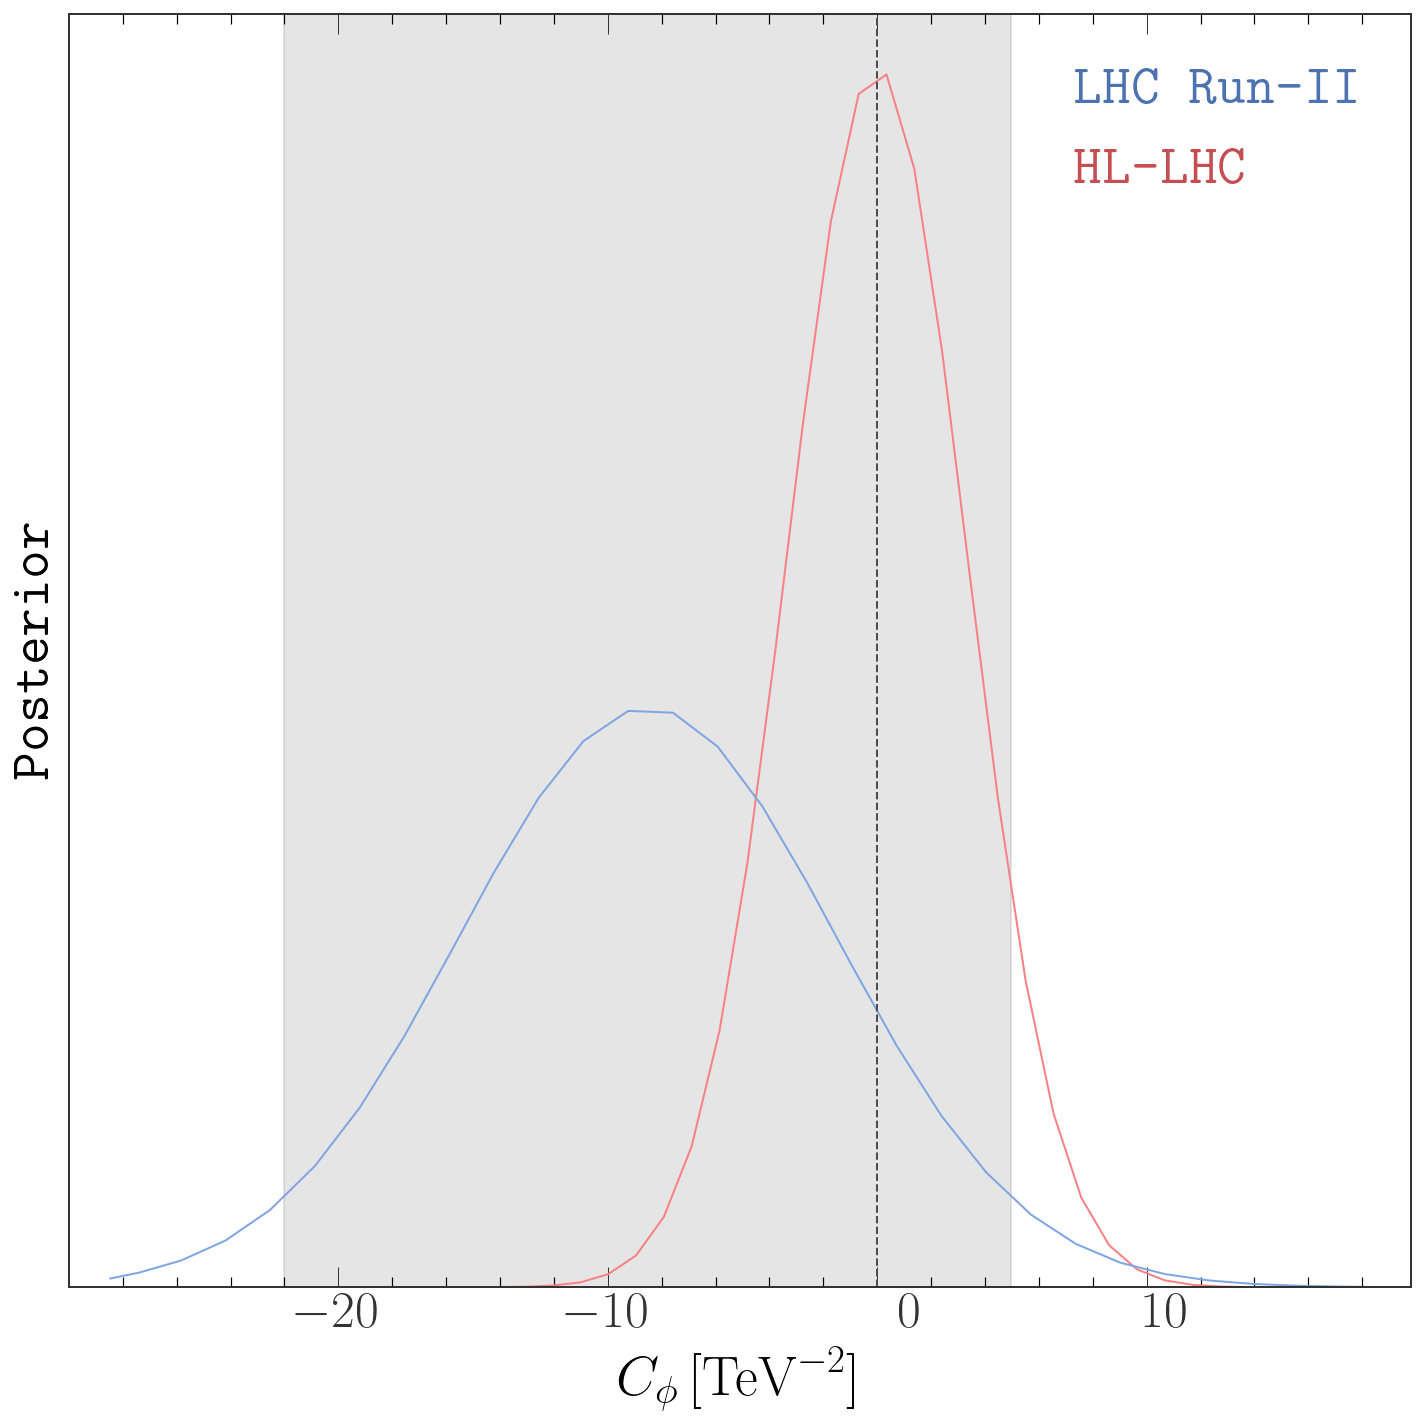

In [4]:

llCqtm =lambda CH : mylikelihoodAV(0,0,0,0,0,CH,data,collider='Run-II',mode='fin',l3mode='linear')

llCqtq =lambda CH : mylikelihoodAV(0,0,0,0,0,CH,data,collider='HL-LHC',mode='fin',l3mode='linear')
limits = [-30, 20]
config = [500000, 0.8, 8]
trace_dir1=dirc+'/results/fits/Cphi_LHC_RunII_linearl3_rge.pickle'
trace_dir2=dirc+'/results/fits/Cphi_HL-LHC_linearl3_rge.pickle'
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config,trace_dir=trace_dir1)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config,trace_dir=trace_dir2)
df_cphi_linear=plotdist(trace_1,trace_2,'../results/plots/single_param/Cphi-linear-fin.pdf','$C_\phi$' ,limits)

## $C_\phi$ quadratic

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 100
Interrupted at 99 [0%]: Average Loss = 13.878
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 794 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 3300
Interrupted at 3,299 [1%]: Average Loss = 2.8398
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 2915 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
        mean        sd  hdi_2.275%  hdi_97.725%         b0        b1
k1 -7.148838  5.694555  -18.067816     3.895241 -18.067816  3.895241
HL-LHC
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1 -0.977099  3.362604   -7.973551     5.282015 -7.973551  5.282015


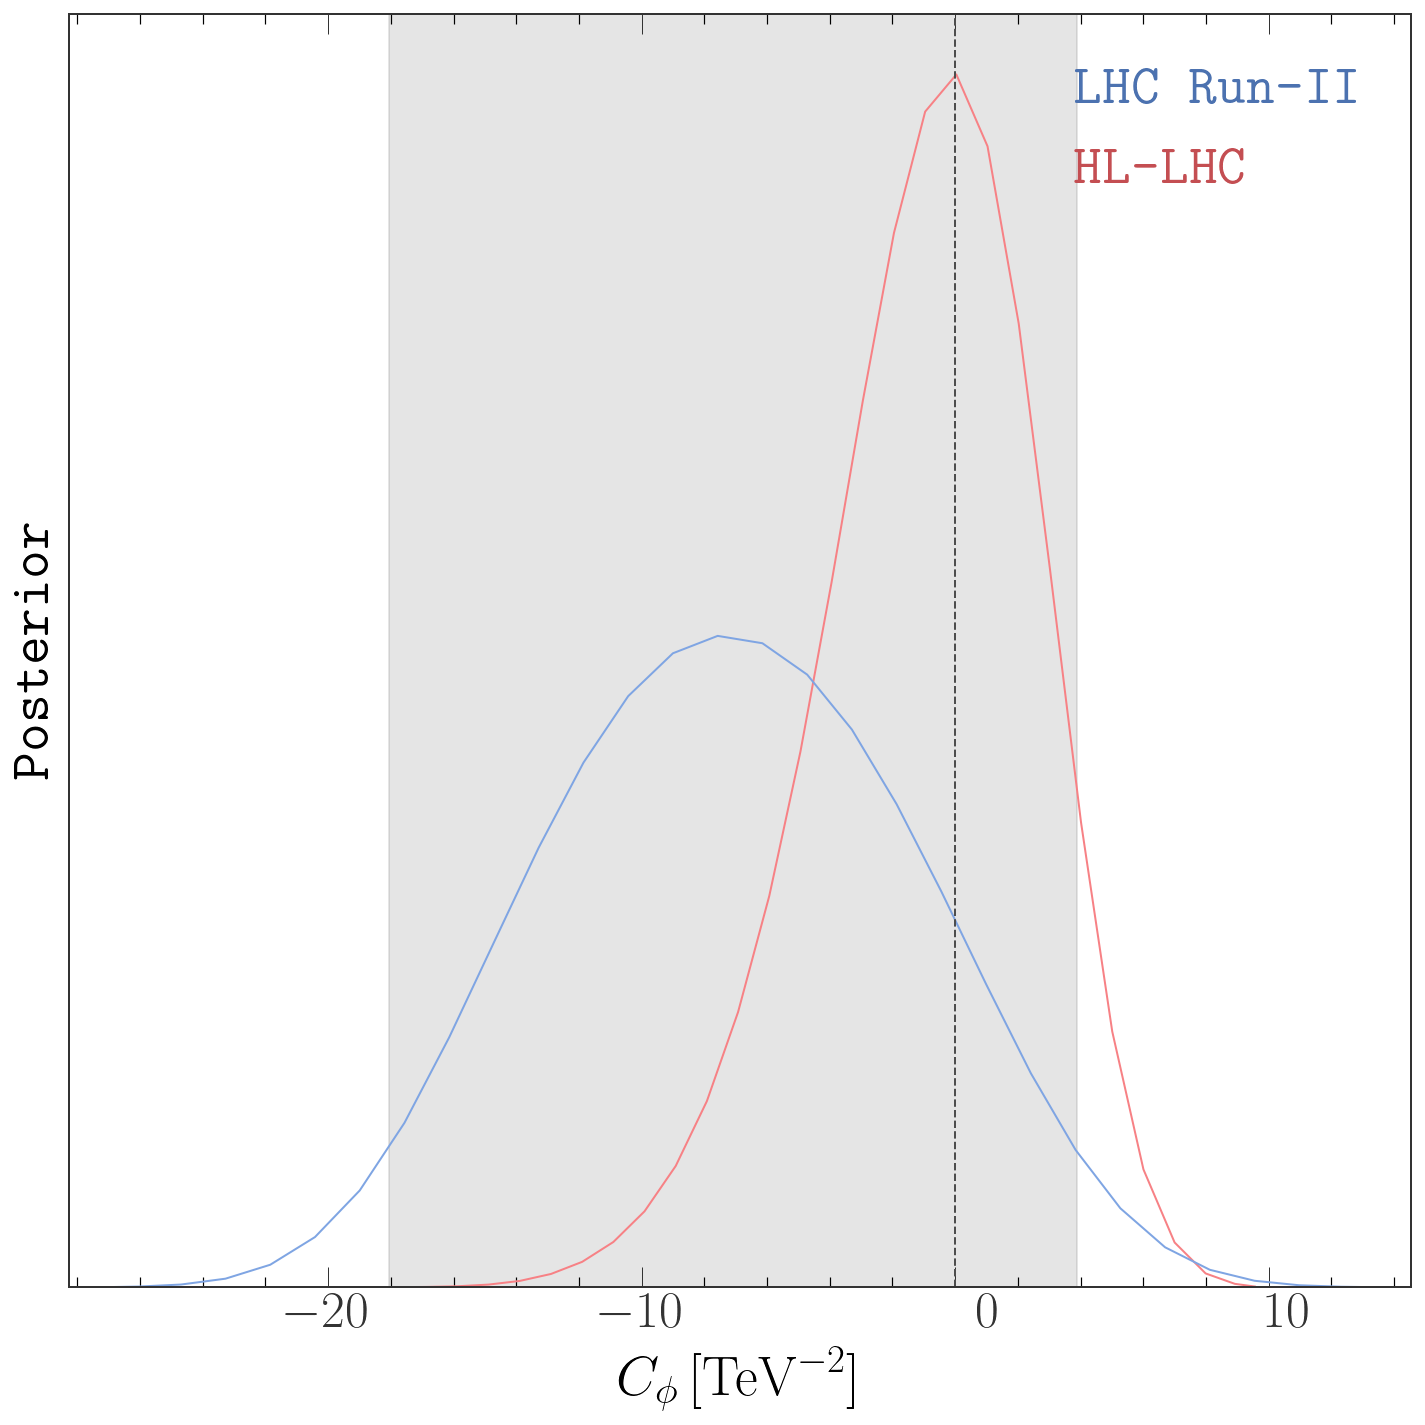

In [5]:
llCqtm =lambda CH : mylikelihoodAV(0,0,0,0,0,CH,data,collider='Run-II',mode='fin',l3mode='quadratic')
llCqtq =lambda CH : mylikelihoodAV(0,0,0,0,0,CH,data,collider='HL-LHC',mode='fin',l3mode='quadratic')
limits = [-30, 20]
config = [500000, 0.8, 8]
trace_dir1=dirc+'/results/fits/Cphi_LHC_RunII_quadl3_rge.pickle'
trace_dir2=dirc+'/results/fits/Cphi_HL-LHC_quadl3_rge.pickle'
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config,trace_dir=trace_dir1)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config,trace_dir=trace_dir2)
df_cphi_quad=plotdist(trace_1,trace_2,'../results/plots/single_param/Cphi-quadratic.pdf','$C_\phi$' ,limits)

## $C_{Qt}^{(1)}$

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 5500
Interrupted at 5,499 [2%]: Average Loss = 15.748
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 688 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 9300
Interrupted at 9,299 [4%]: Average Loss = 8.1872
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 1196 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1 -0.314826  0.326227   -0.966409     0.338453 -0.966409  0.338453
HL-LHC
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1  0.000113  0.144829   -0.288761     0.290552 -0.288761  0.290552


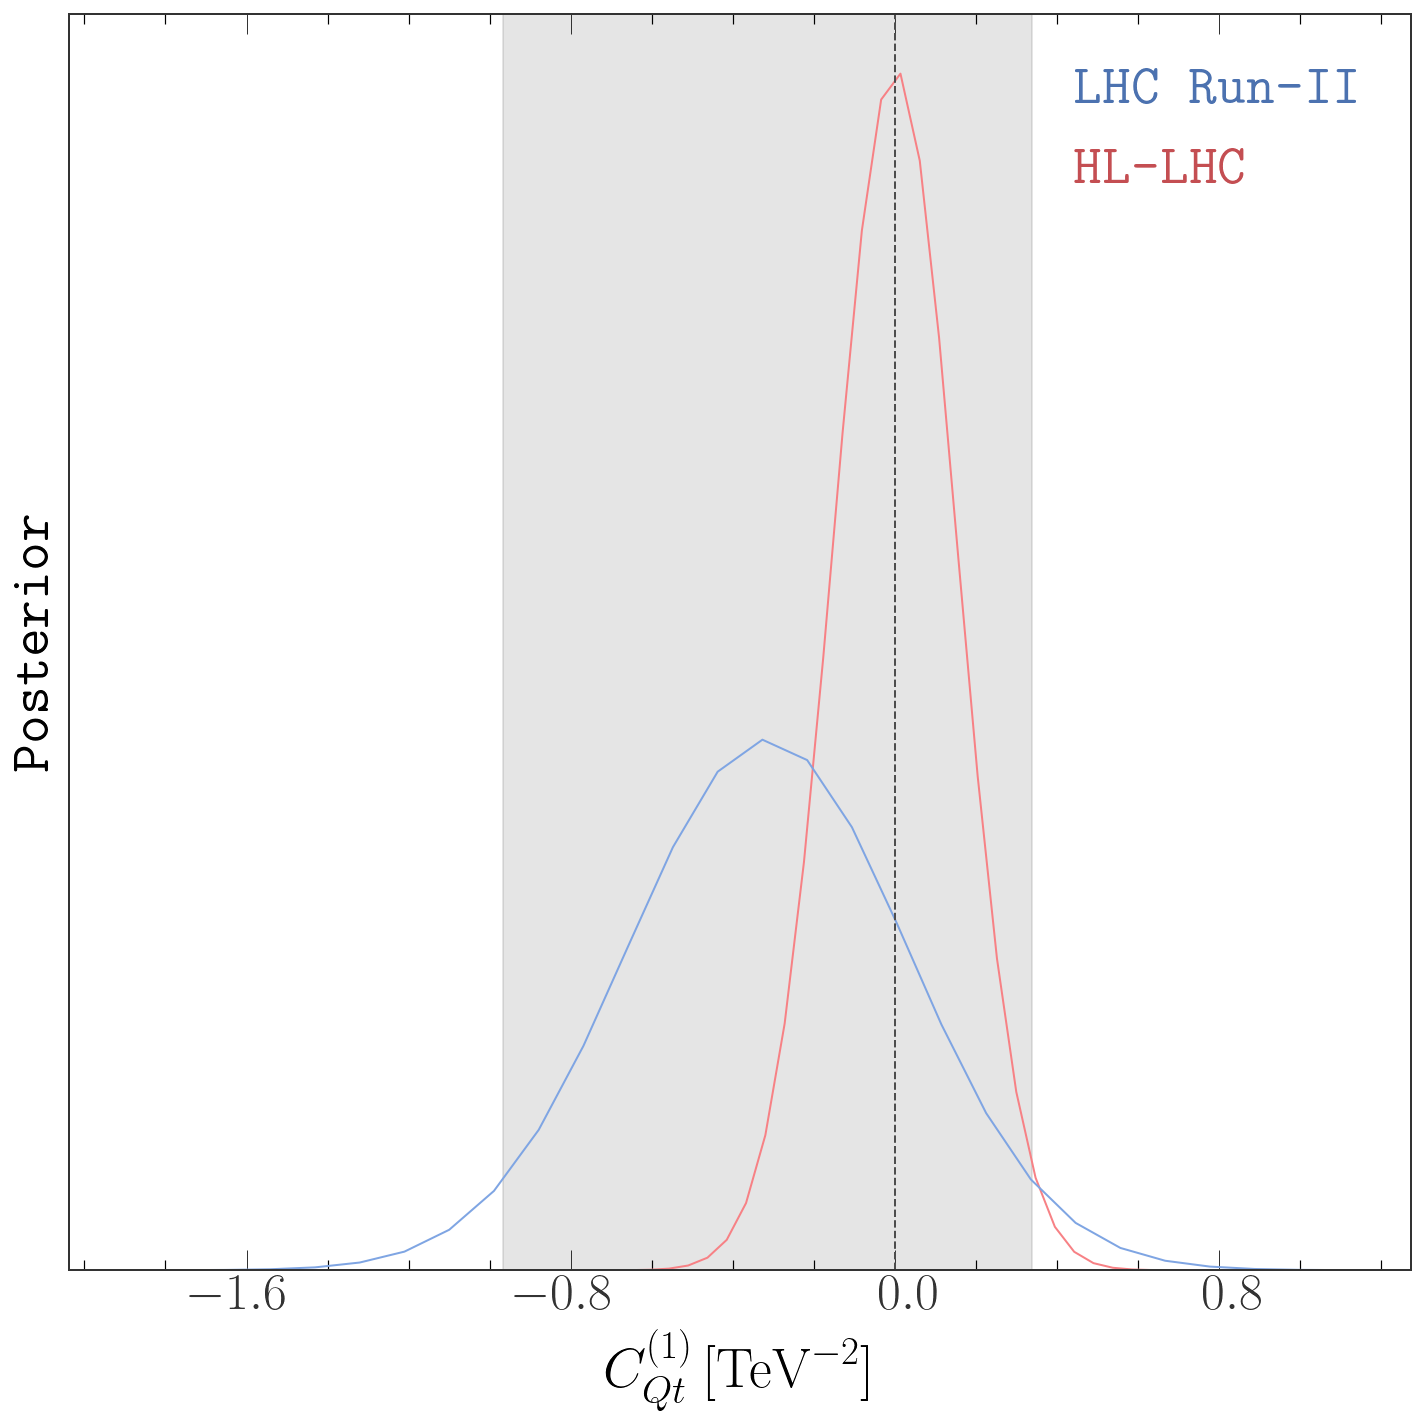

In [3]:
llCqtm =lambda cqt1 :mylikelihoodAV(cqt1,0,0,0,0,0,data,collider='Run-II',mode='rge',l3mode='quadratic')

llCqtq =lambda cqt1 :mylikelihoodAV(cqt1,0,0,0,0,0,data,collider='HL-LHC',mode='rge',l3mode='quadratic')
limits = [-3, 3]
config = [500000, 0.8, 8]
trace_dir1=dirc+'/results/fits/Cqt1_LHC_RunII_rge.pickle'
trace_dir2=dirc+'/results/fits/Cqt1_HL-LHC_rge.pickle'
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config,trace_dir=trace_dir1)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config,trace_dir=trace_dir2)
df_cqt1=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqt1.pdf','$C_{Qt}^{(1)}$' ,limits)

## $C_{Qt}^{(8)}$

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 100
Interrupted at 99 [0%]: Average Loss = 14.083
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 707 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 5700
Interrupted at 5,699 [2%]: Average Loss = 3.203
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 1218 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1  1.581304  1.702798   -1.820047     4.992862 -1.820047  4.992862
HL-LHC
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1 -0.000566  0.736878   -1.475417     1.472304 -1.475417  1.472304


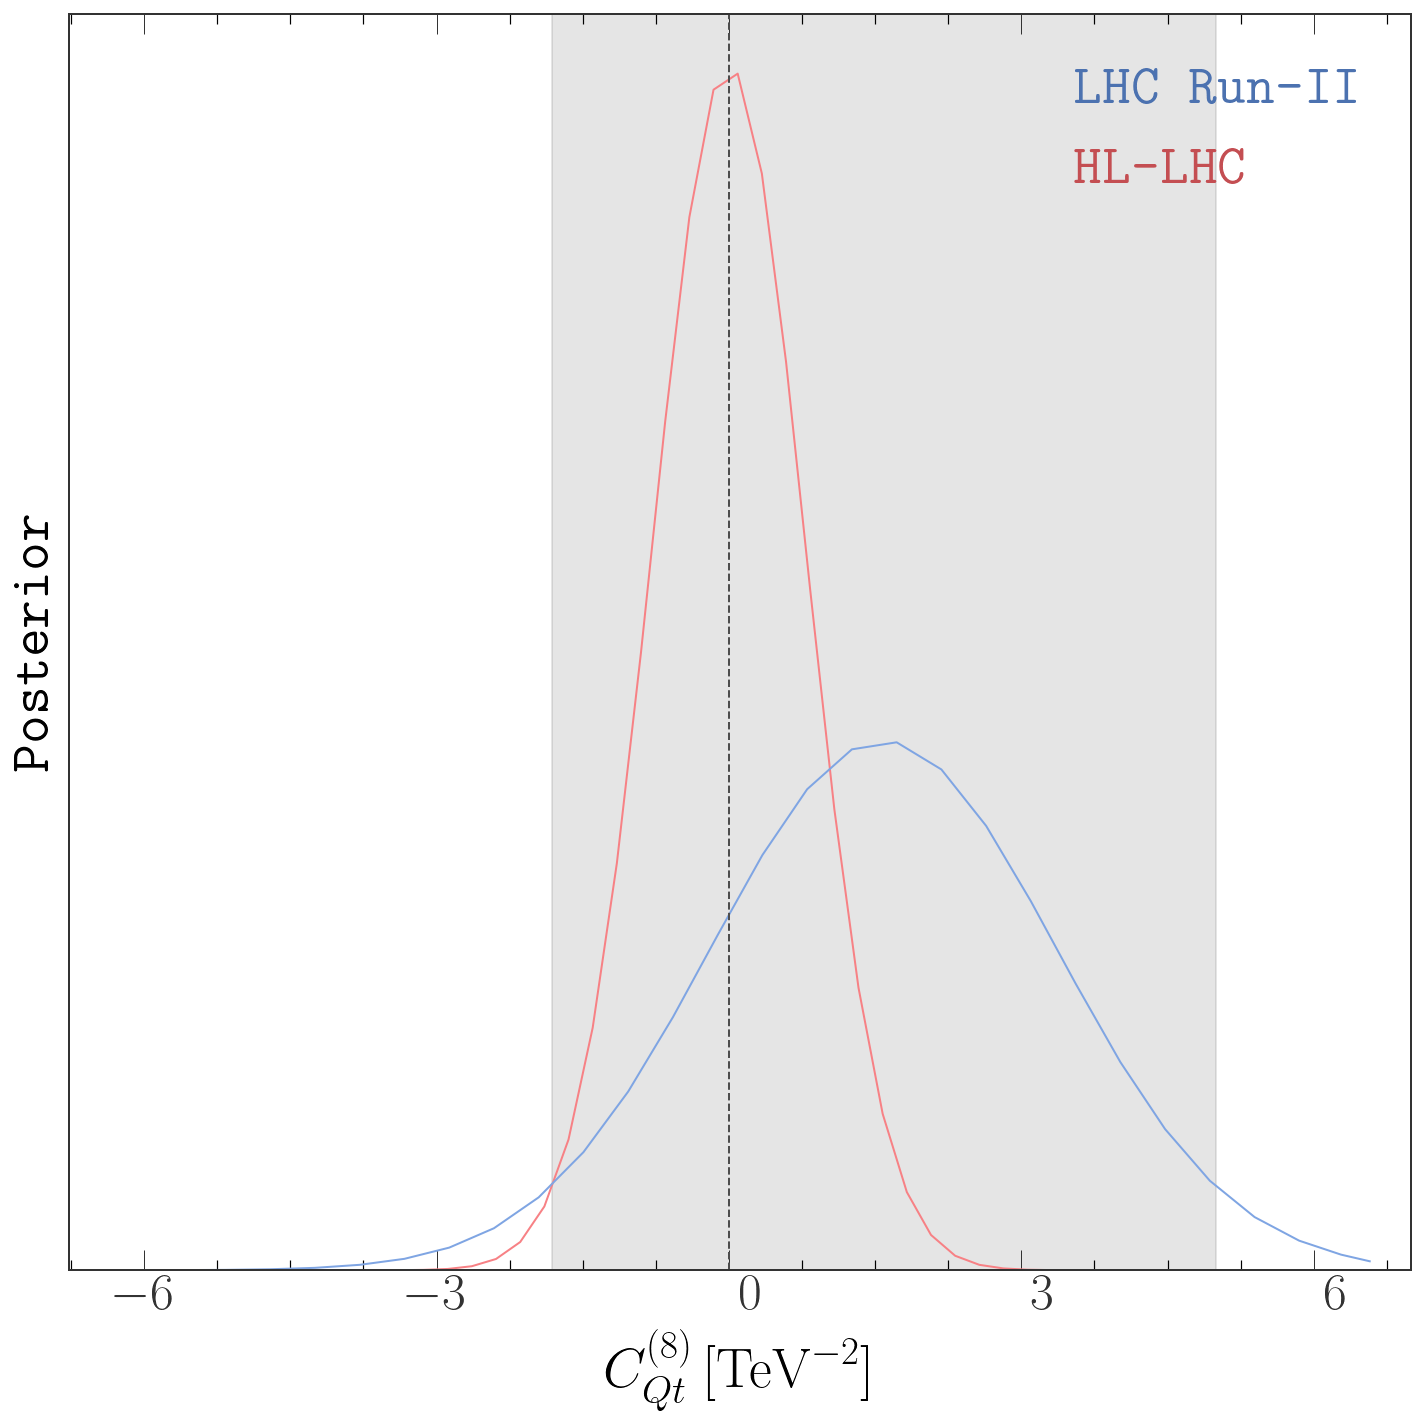

In [10]:
llCqtm =lambda cqt1 :mylikelihoodAV(0,cqt1,0,0,0,0,data,collider='Run-II',mode='rge',l3mode='quadratic')

llCqtq =lambda cqt1 :mylikelihoodAV(0,cqt1,0,0,0,0,data,collider='HL-LHC',mode='rge',l3mode='quadratic')
limits = [-7, 7]
config = [500000, 0.8, 8]

trace_dir1=dirc+'/results/fits/Cqt8_LHC_RunII_rge.pickle'
trace_dir2=dirc+'/results/fits/Cqt8_HL-LHC_rge.pickle'
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config,trace_dir=trace_dir1)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config,trace_dir=trace_dir2)
df_cqt8=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqt8.pdf','$C_{Qt}^{(8)}$' ,limits)

## $C_{QtQb}^{(1)}$

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 4400
Interrupted at 4,399 [2%]: Average Loss = 15.639
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 693 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 8800
Interrupted at 8,799 [4%]: Average Loss = 5.9674
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 1195 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1  0.099389  0.120621   -0.143199     0.339633 -0.143199  0.339633
HL-LHC
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1  0.000007  0.059972   -0.120232     0.119616 -0.120232  0.119616


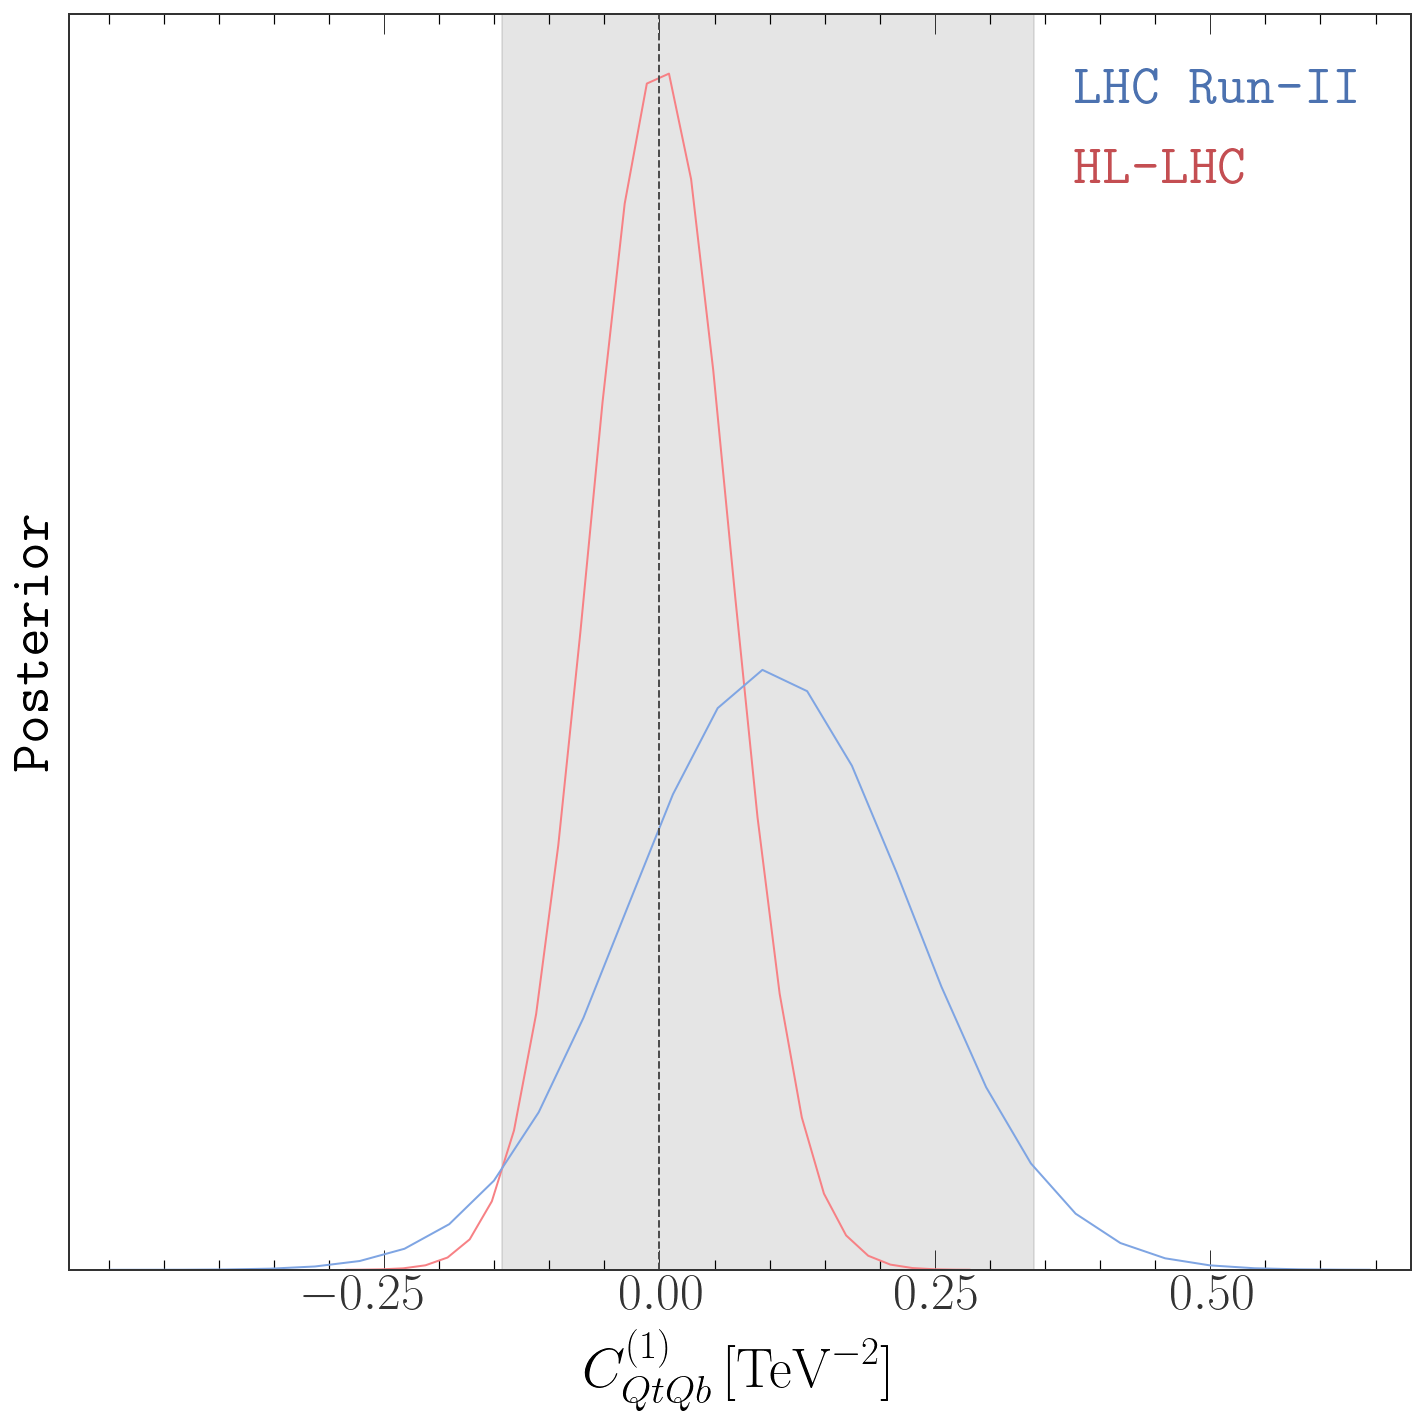

In [6]:
llCqtm =lambda cqt1 :mylikelihoodAV(0,0,cqt1,0,0,0,data,collider='Run-II',mode='rge',l3mode='quadratic')

llCqtq =lambda cqt1 :mylikelihoodAV(0,0,cqt1,0,0,0,data,collider='HL-LHC',mode='rge',l3mode='quadratic')
limits = [-1., 1.]
config = [500000, 0.8, 8]
trace_dir1=dirc+'/results/fits/Cqtqb1_LHC_RunII_rge.pickle'
trace_dir2=dirc+'/results/fits/Cqtqb1_HL-LHC_rge.pickle'
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config,trace_dir=trace_dir1)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config,trace_dir=trace_dir2)
df_cqtqb1=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqtqb1.pdf','$C_{QtQb}^{(1)}$' ,limits)

## $C_{QtQb}^{(8)}$

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 100
Interrupted at 99 [0%]: Average Loss = 13.996
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 713 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 3500
Interrupted at 3,499 [1%]: Average Loss = 2.5722
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 1224 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1  0.518933  0.629565   -0.738398     1.781555 -0.738398  1.781555
HL-LHC
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1 -0.000069  0.315143   -0.629081     0.630907 -0.629081  0.630907


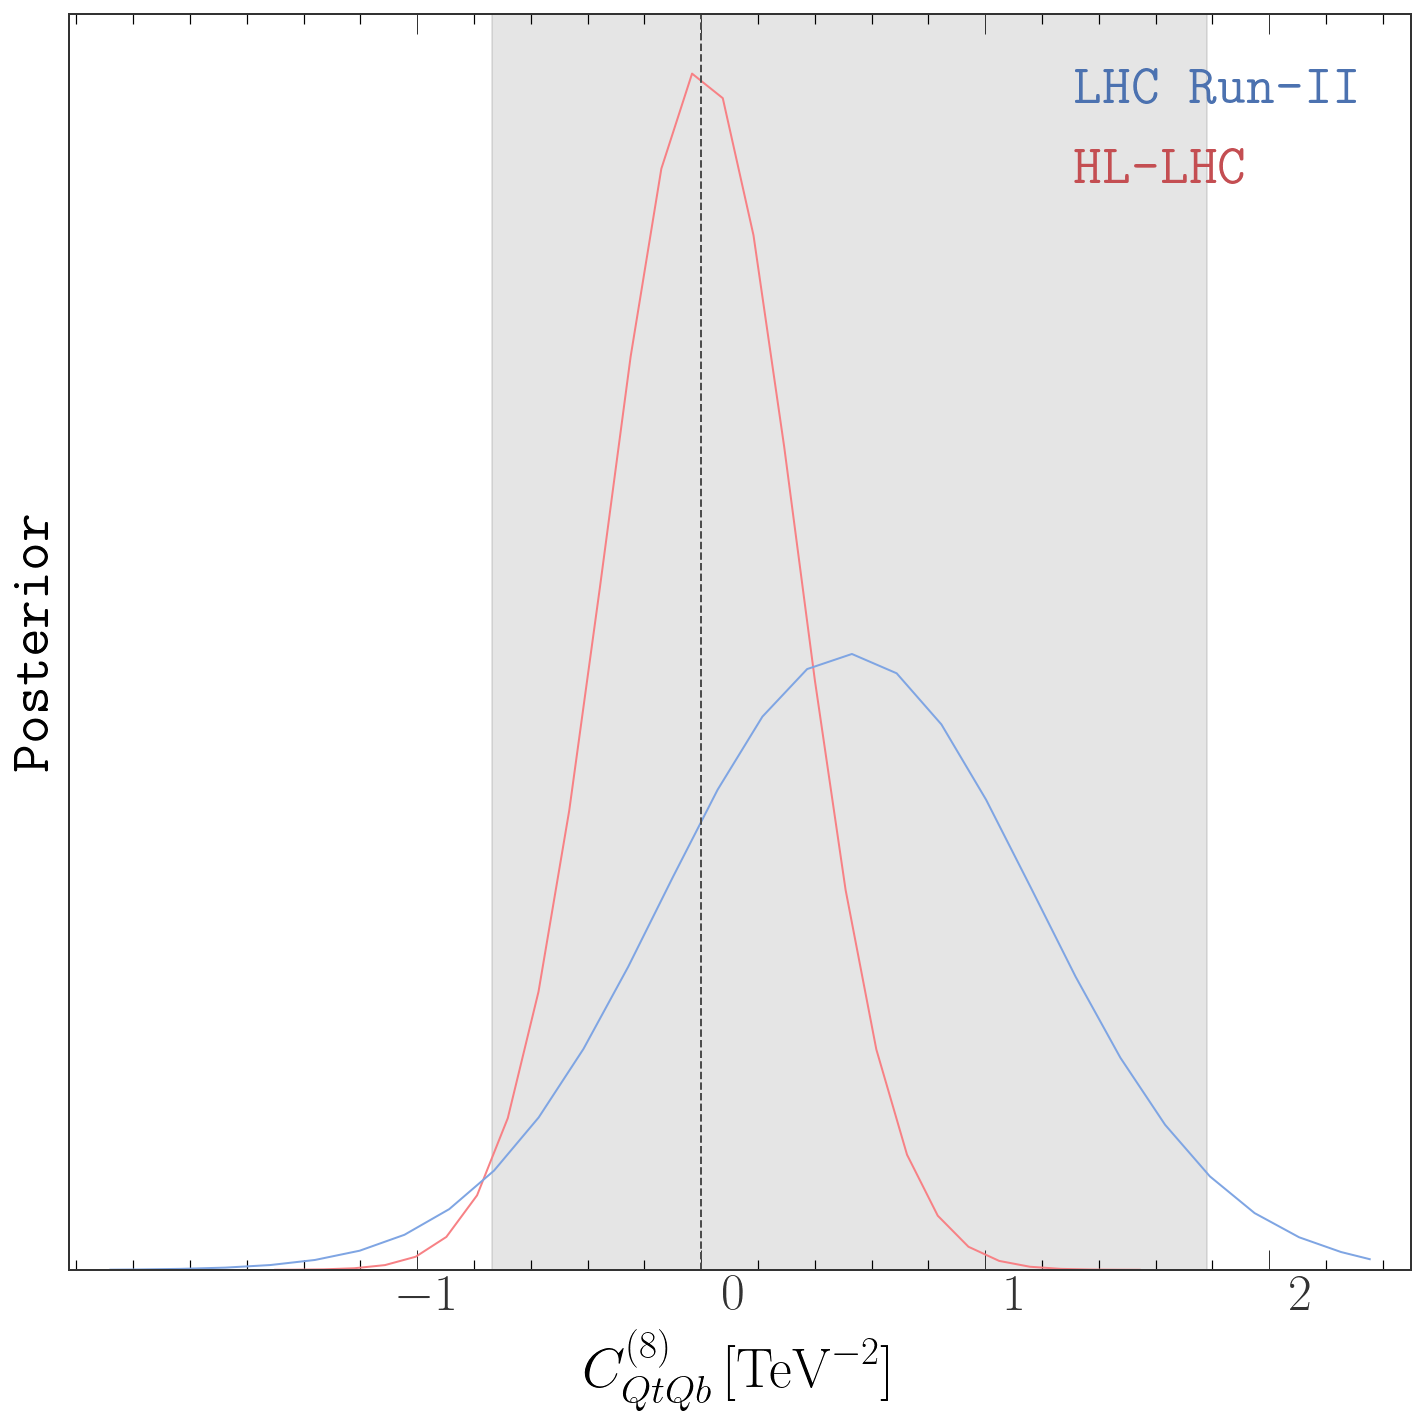

In [7]:
llCqtm =lambda cqt1 :mylikelihoodAV(0,0,0,cqt1,0,0,data,collider='Run-II',mode='rge',l3mode='quadratic')

llCqtq =lambda cqt1 :mylikelihoodAV(0,0,0,cqt1,0,0,data,collider='HL-LHC',mode='rge',l3mode='quadratic')
limits = [-2.25, 2.5]
config = [500000, 0.8, 8]
trace_dir1=dirc+'/results/fits/Cqtqb8_LHC_RunII_rge.pickle'
trace_dir2=dirc+'/results/fits/Cqtqb8_HL-LHC_rge.pickle'
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config,trace_dir=trace_dir1)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config,trace_dir=trace_dir2)
df_cqtqb8=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqtqb8.pdf','$C_{QtQb}^{(8)}$' ,limits)

## $C_{QQ}^{(3)}$

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 100
Interrupted at 99 [0%]: Average Loss = 13.997
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 10_000 tune and 50_000 draw iterations (80_000 + 400_000 draws total) took 61 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 4100
Interrupted at 4,099 [2%]: Average Loss = 2.8145
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 10_000 tune and 50_000 draw iterations (80_000 + 400_000 draws total) took 65 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
         mean         sd  hdi_2.275%  hdi_97.725%          b0         b1
k1 -47.603842  48.844369 -144.787264    50.635705 -144.787264  50.635705
HL-LHC
       mean         sd  hdi_2.275%  hdi_97.725%         b0         b1
k1 -0.02422  20.580792  -40.910331    41.323224 -40.910331  41.323224


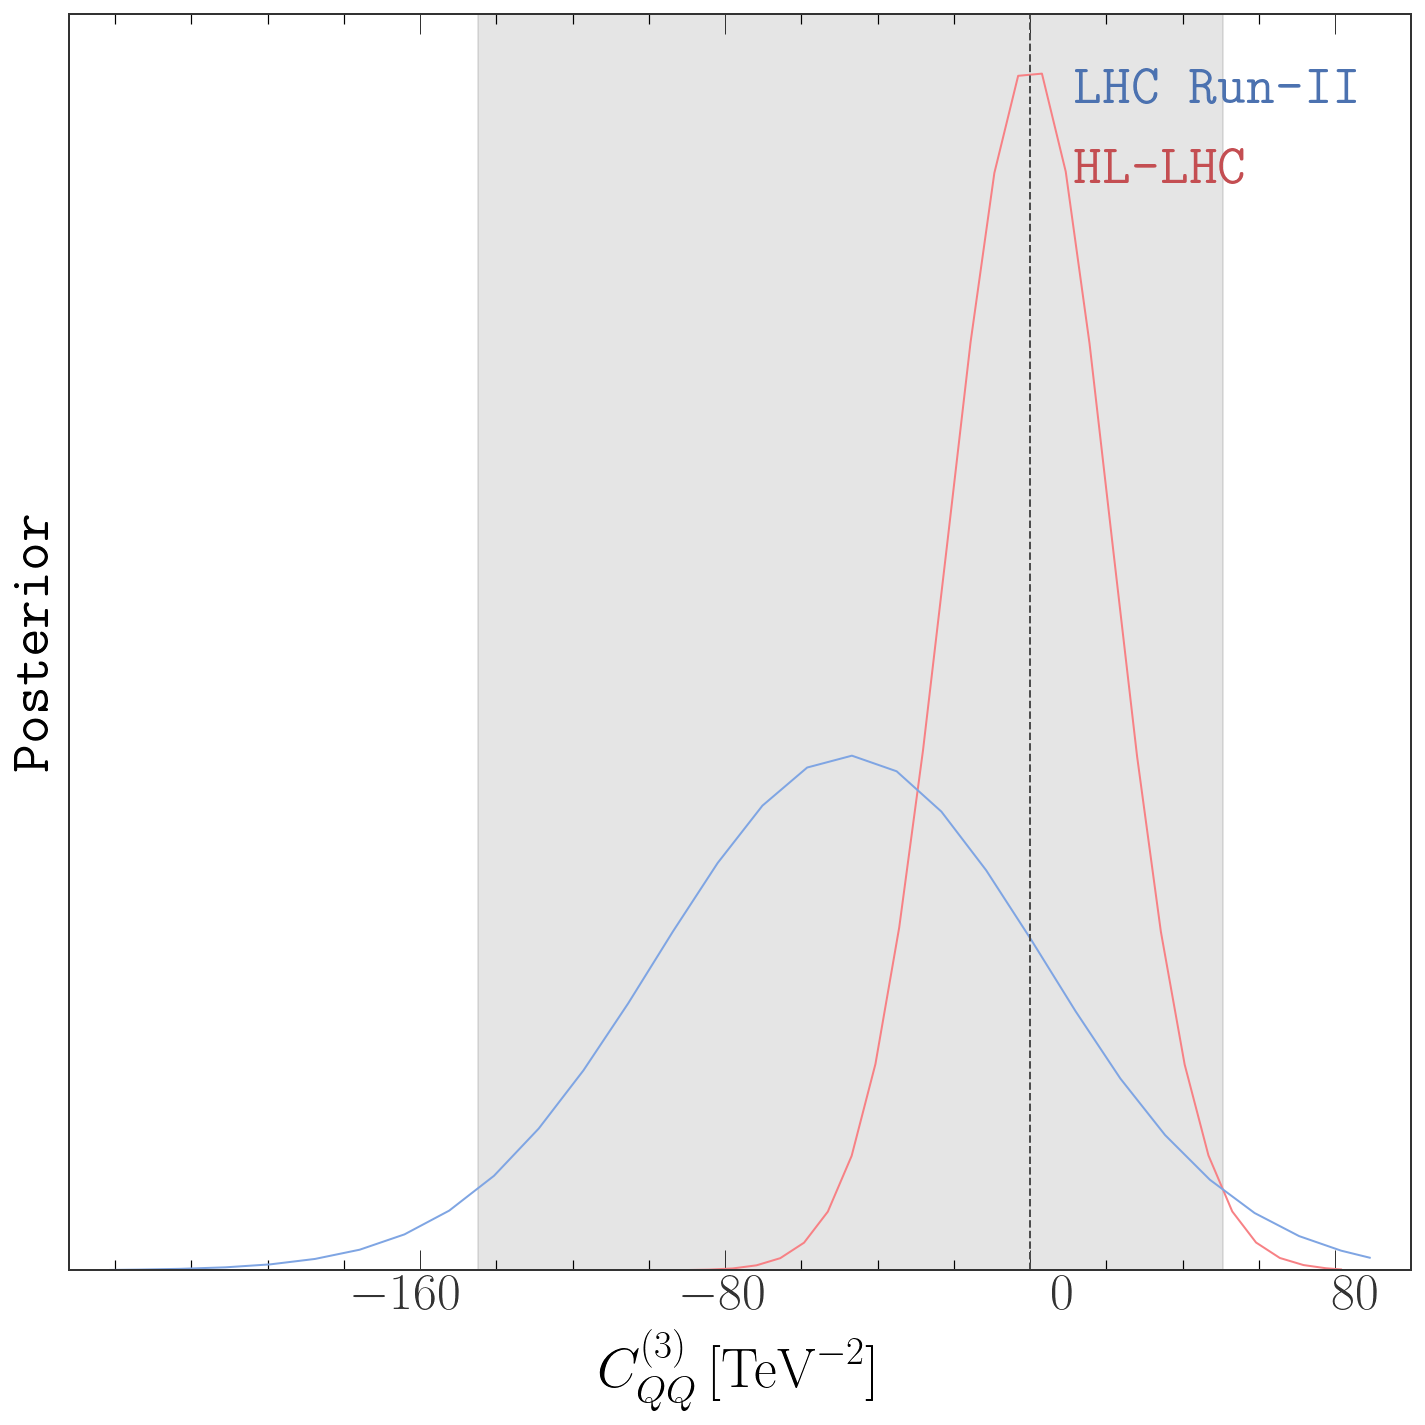

In [5]:
llCqtm =lambda cqt1 :mylikelihoodAV(0,0,0,0,cqt1,0,data,collider='Run-II',mode='rge',l3mode='quadratic')

llCqtq =lambda cqt1 :mylikelihoodAV(0,0,0,0,cqt1,0,data,collider='HL-LHC',mode='rge',l3mode='quadratic')
limits = [-300, 100]
config = [50000, 0.8, 8]
trace_dir1=dirc+'/results/fits/Cqq3_LHC_RunII_rge.pickle'
trace_dir2=dirc+'/results/fits/Cqq3_HL-LHC_rge.pickle'
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config,trace_dir=trace_dir1)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config,trace_dir=trace_dir2)
df_cqtqb8=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqq1.pdf','$C_{QQ}^{(3)}$' ,limits)

## $C_{tt}$

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 700
Interrupted at 699 [0%]: Average Loss = 13.437
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 602 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 100
Interrupted at 99 [0%]: Average Loss = 1.7836
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 595 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
          mean          sd  hdi_2.275%  hdi_97.725%          b0         b1
k1 -113.380936  100.864646 -301.285907    88.032315 -301.285907  88.032315
HL-LHC
        mean         sd  hdi_2.275%  hdi_97.725%         b0         b1
k1 -0.796768  39.882002  -79.068671    79.571514 -79.068671  79.571514


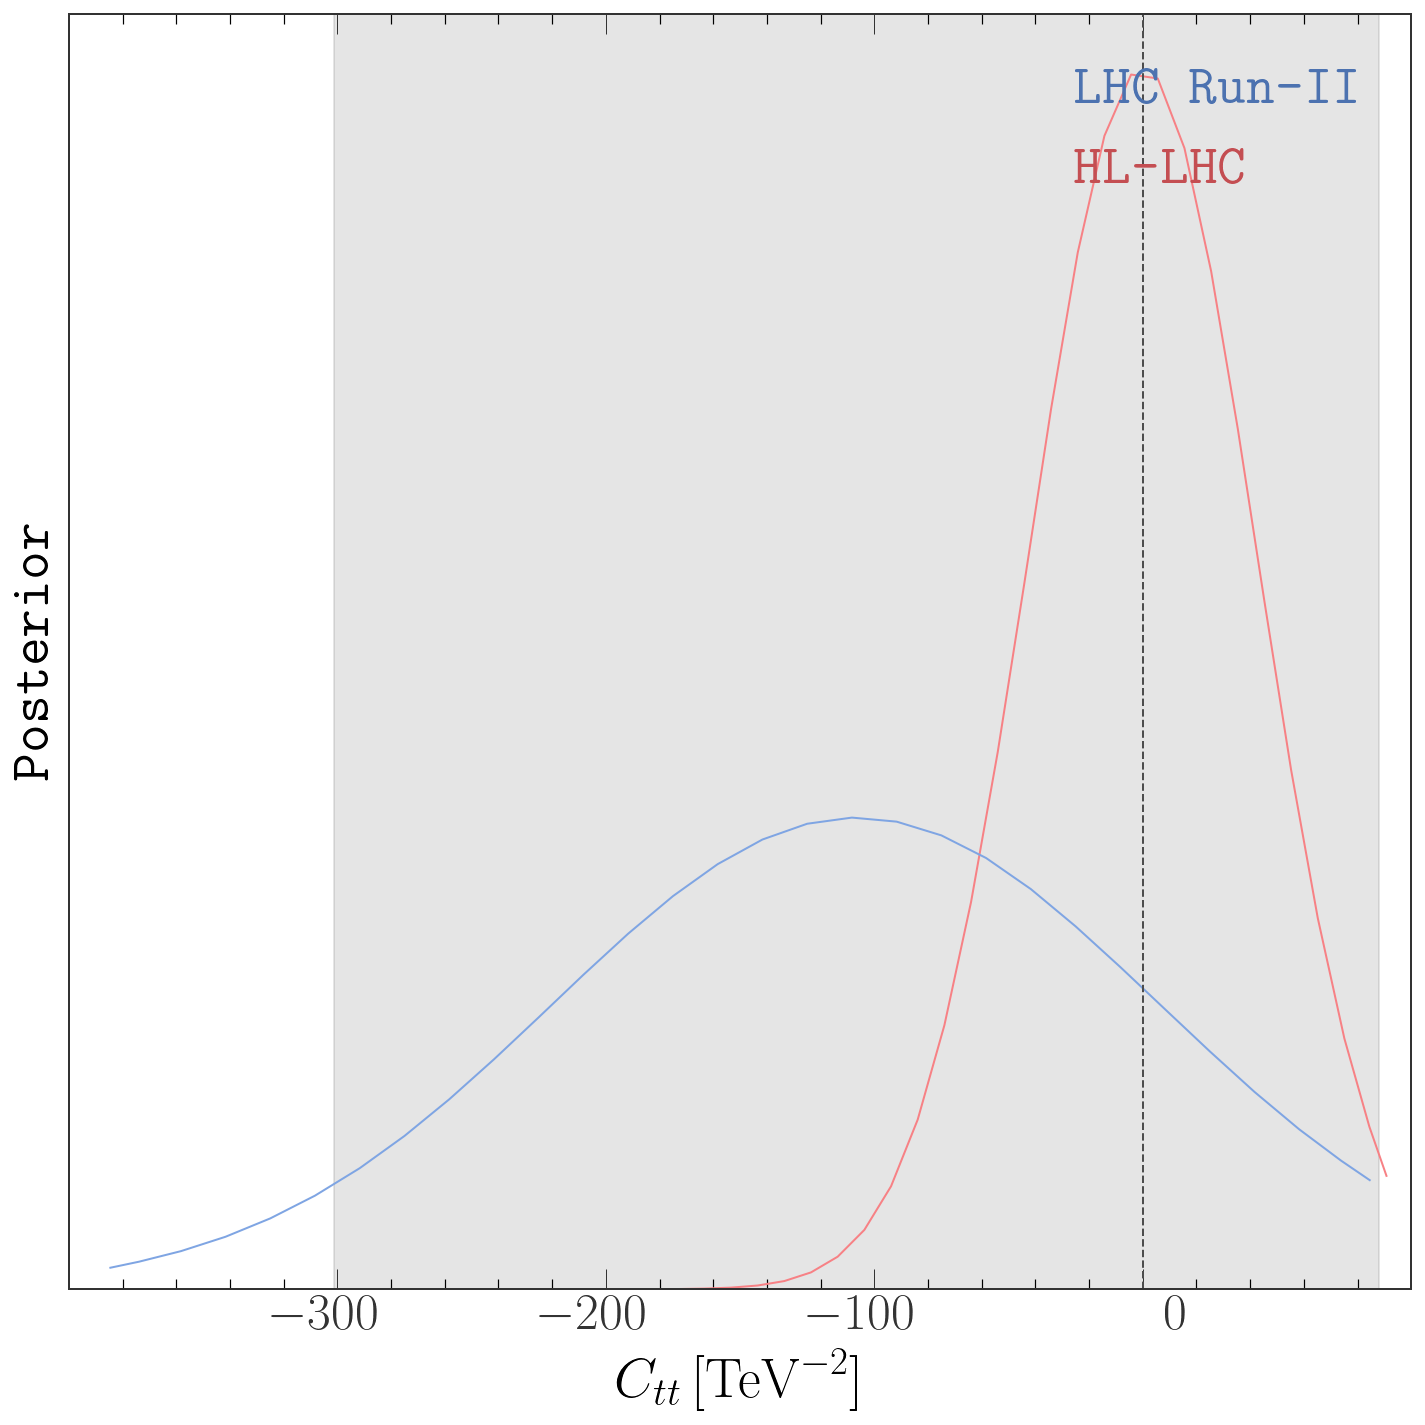

In [10]:
llCqtm =lambda cqt1 :mylikelihoodAV(0,0,0,0,cqt1,0,data,collider='Run-II',mode='rge',l3mode='quadratic',operator='Ctt1')

llCqtq =lambda cqt1 :mylikelihoodAV(0,0,0,0,cqt1,0,data,collider='HL-LHC',mode='rge',l3mode='quadratic',operator='Ctt1')
limits = [-400, 100]
config = [500000, 0.8, 8]
trace_dir1=dirc+'/results/fits/Ctt_LHC_RunII_rge.pickle'
trace_dir2=dirc+'/results/fits/Ctt_HL-LHC_rge.pickle'
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config,trace_dir=trace_dir1)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config,trace_dir=trace_dir2)
df_cqtqb8=plotdist(trace_1,trace_2,'../results/plots/single_param/tt.pdf','$C_{tt}$' ,limits)

## $C_{QQ}^{1}$

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 100
Interrupted at 99 [0%]: Average Loss = 13.771
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 594 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 2900
Interrupted at 2,899 [1%]: Average Loss = 2.4136
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 100_000 tune and 500_000 draw iterations (800_000 + 4_000_000 draws total) took 596 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
         mean         sd  hdi_2.275%  hdi_97.725%         b0         b1
k1  26.357249  27.299116  -28.087127    81.291932 -28.087127  81.291932
HL-LHC
        mean         sd  hdi_2.275%  hdi_97.725%        b0        b1
k1  0.001575  13.081671   -26.19475     26.09105 -26.19475  26.09105


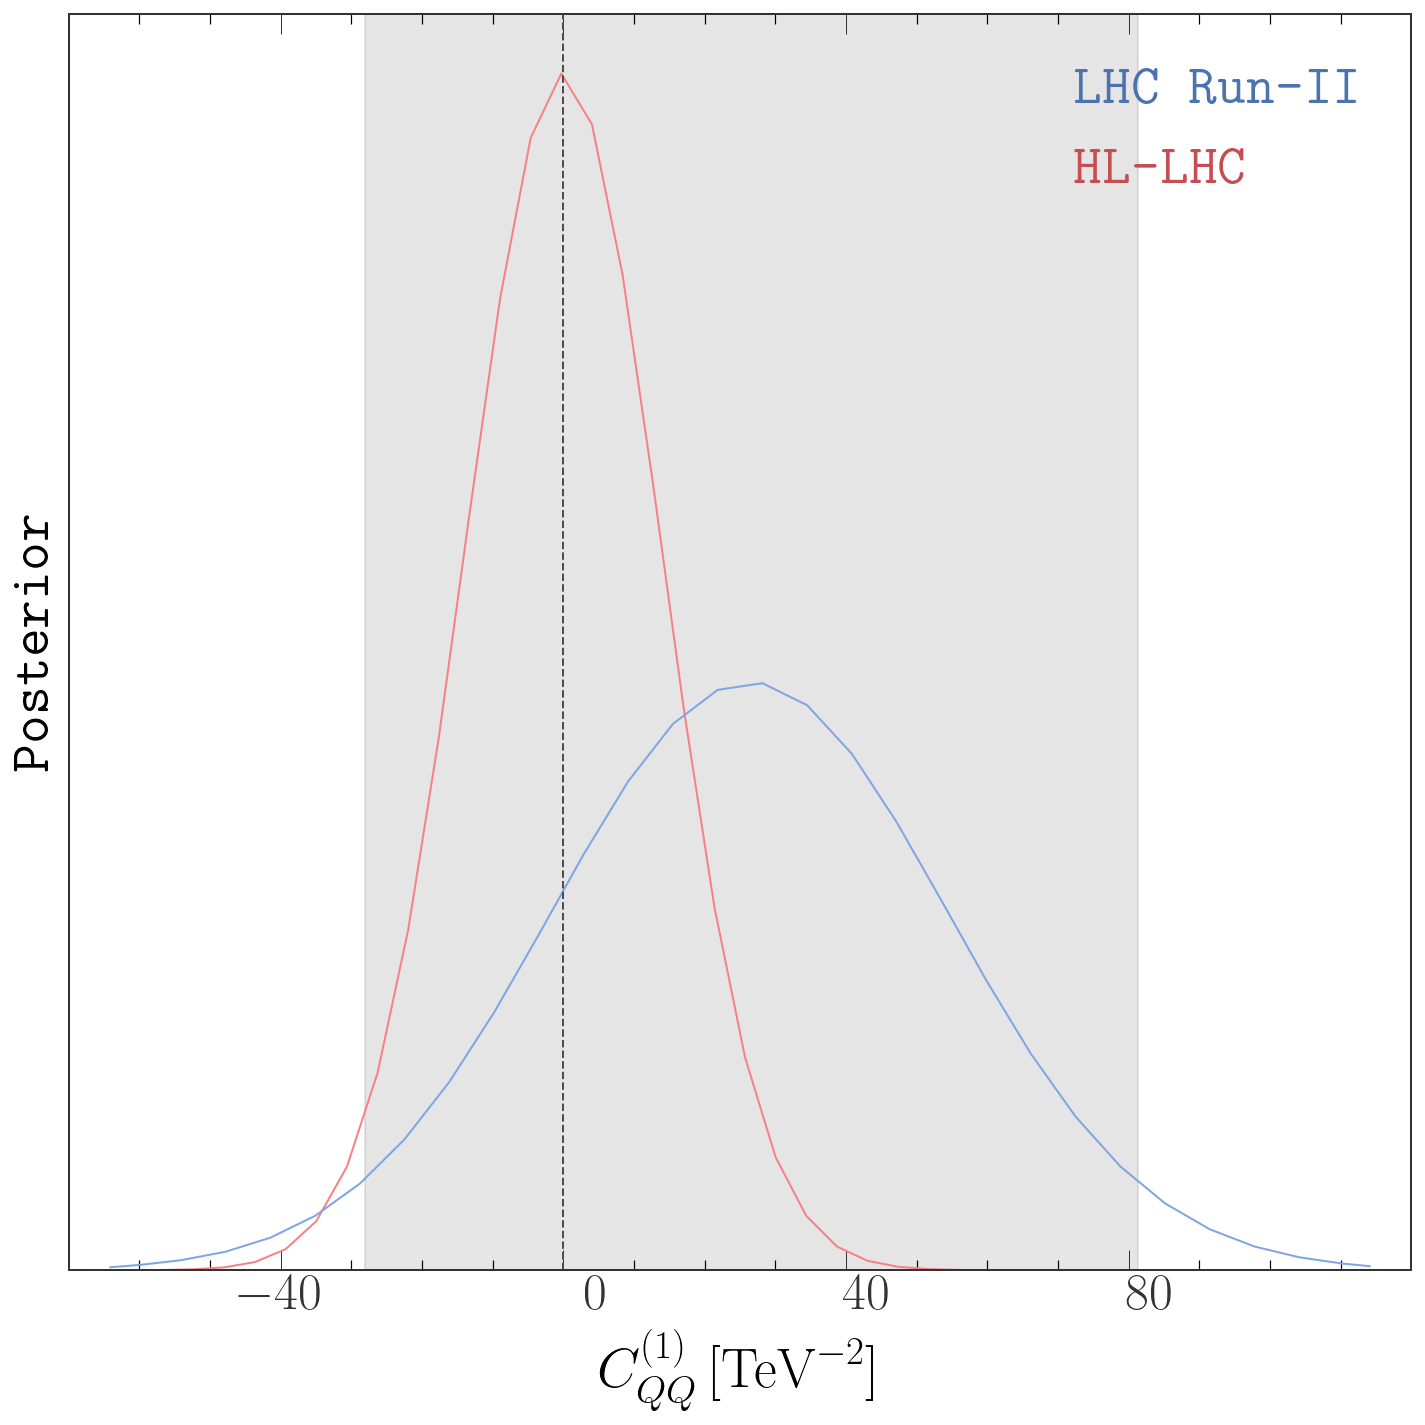

In [8]:
llCqtm =lambda cqt1 :mylikelihoodAV(0,0,0,0,cqt1,0,data,collider='Run-II',mode='rge',l3mode='quadratic',operator='Cqq1')

llCqtq =lambda cqt1 :mylikelihoodAV(0,0,0,0,cqt1,0,data,collider='HL-LHC',mode='rge',l3mode='quadratic',operator='Cqq1')
limits = [-70, 120]
config = [500000, 0.8, 8]
trace_dir1=dirc+'/results/fits/Cqq1_LHC_RunII_rge.pickle'
trace_dir2=dirc+'/results/fits/Cqq1_HL-LHC_rge.pickle'
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config,trace_dir=trace_dir1)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config,trace_dir=trace_dir2)
df_cqtqb8=plotdist(trace_1,trace_2,'../results/plots/single_param/qq1.pdf','$C_{QQ}^{(1)}$' ,limits)

## Obtaining lambda

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 1400
Interrupted at 1,399 [0%]: Average Loss = 19.82
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 10_000 tune and 50_000 draw iterations (80_000 + 400_000 draws total) took 82 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 3700
Interrupted at 3,699 [1%]: Average Loss = 7.8771
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 10_000 tune and 50_000 draw iterations (80_000 + 400_000 draws total) took 384 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1  0.170342  0.055603    0.071831     0.282943  0.071831  0.282943
HL-LHC
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1  0.266898  0.070699    0.143018     0.412041  0.143018  0.412041


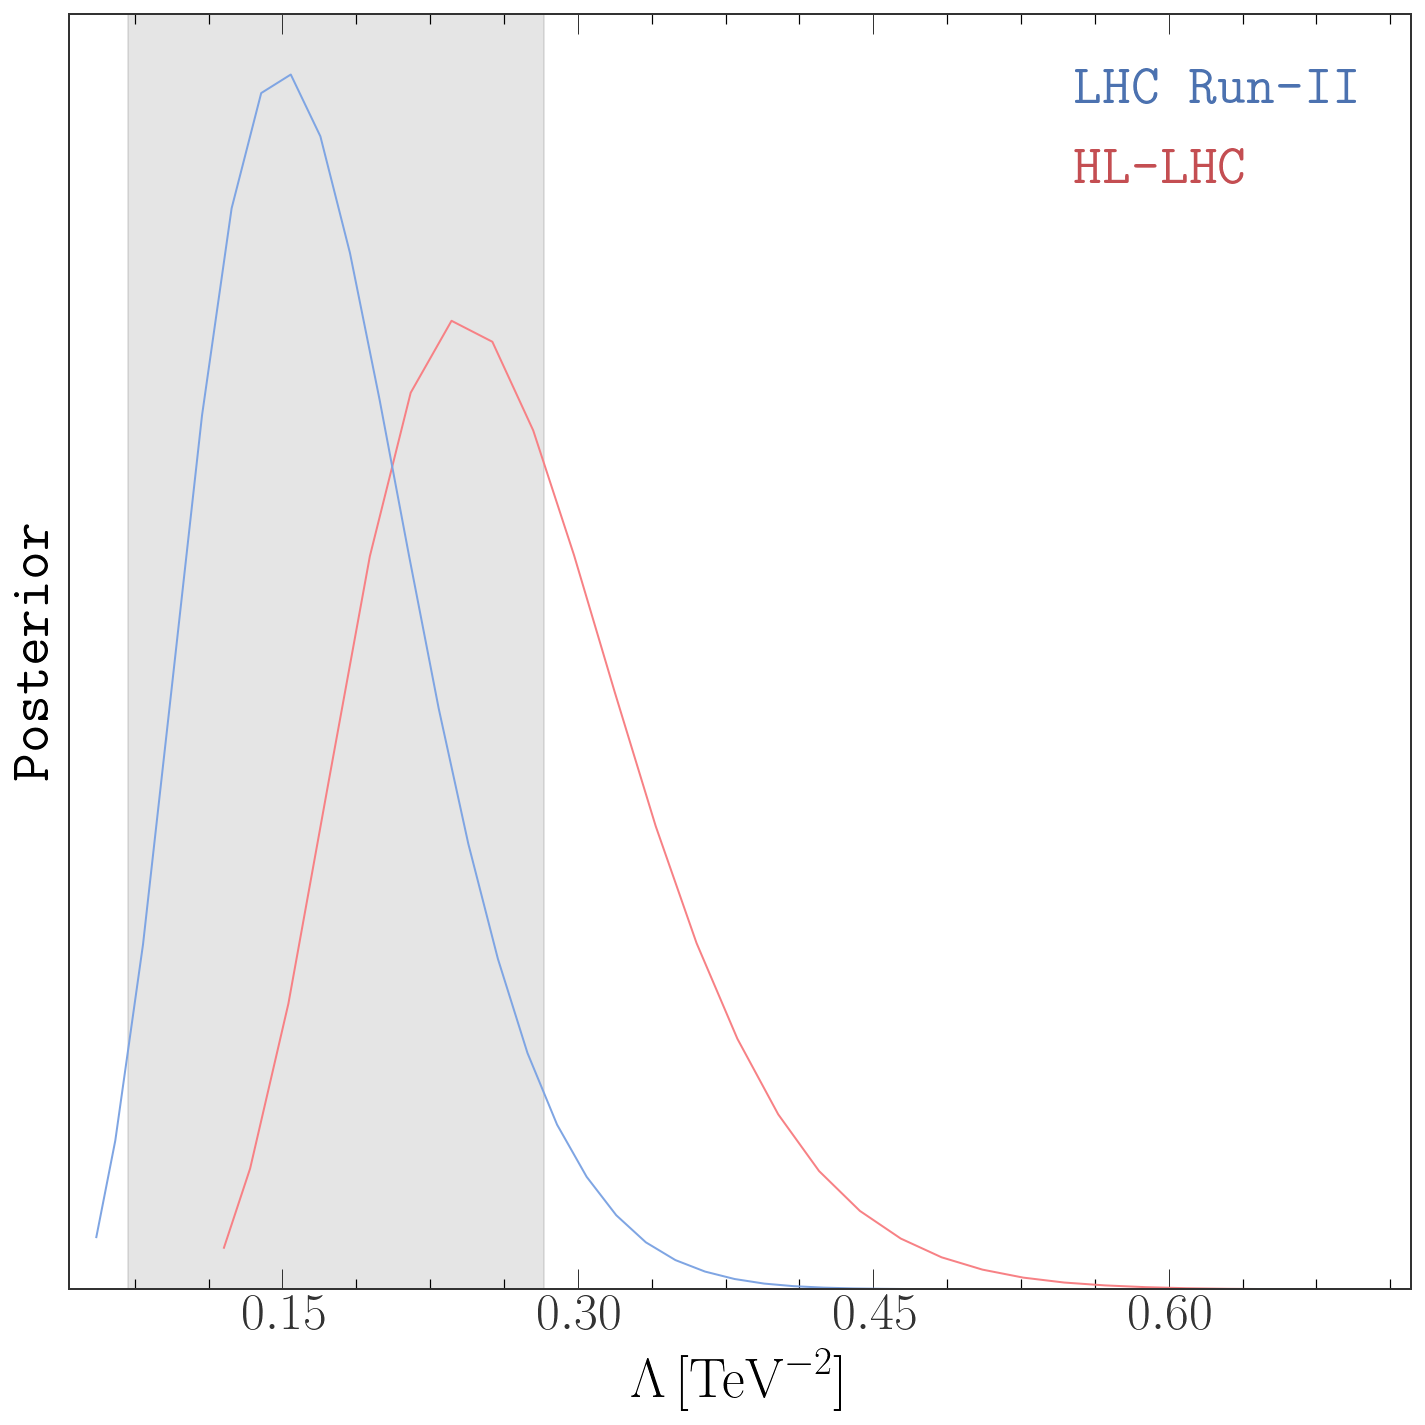

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 600
Interrupted at 599 [0%]: Average Loss = 15.731
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 10_000 tune and 50_000 draw iterations (80_000 + 400_000 draws total) took 82 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 300
Interrupted at 299 [0%]: Average Loss = 3.7806
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 10_000 tune and 50_000 draw iterations (80_000 + 400_000 draws total) took 404 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
        mean        sd  hdi_2.275%  hdi_97.725%        b0       b1
k1  0.452119  0.221731    0.093263      0.89897  0.093263  0.89897
HL-LHC
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1  0.388725  0.131372    0.160619     0.652382  0.160619  0.652382


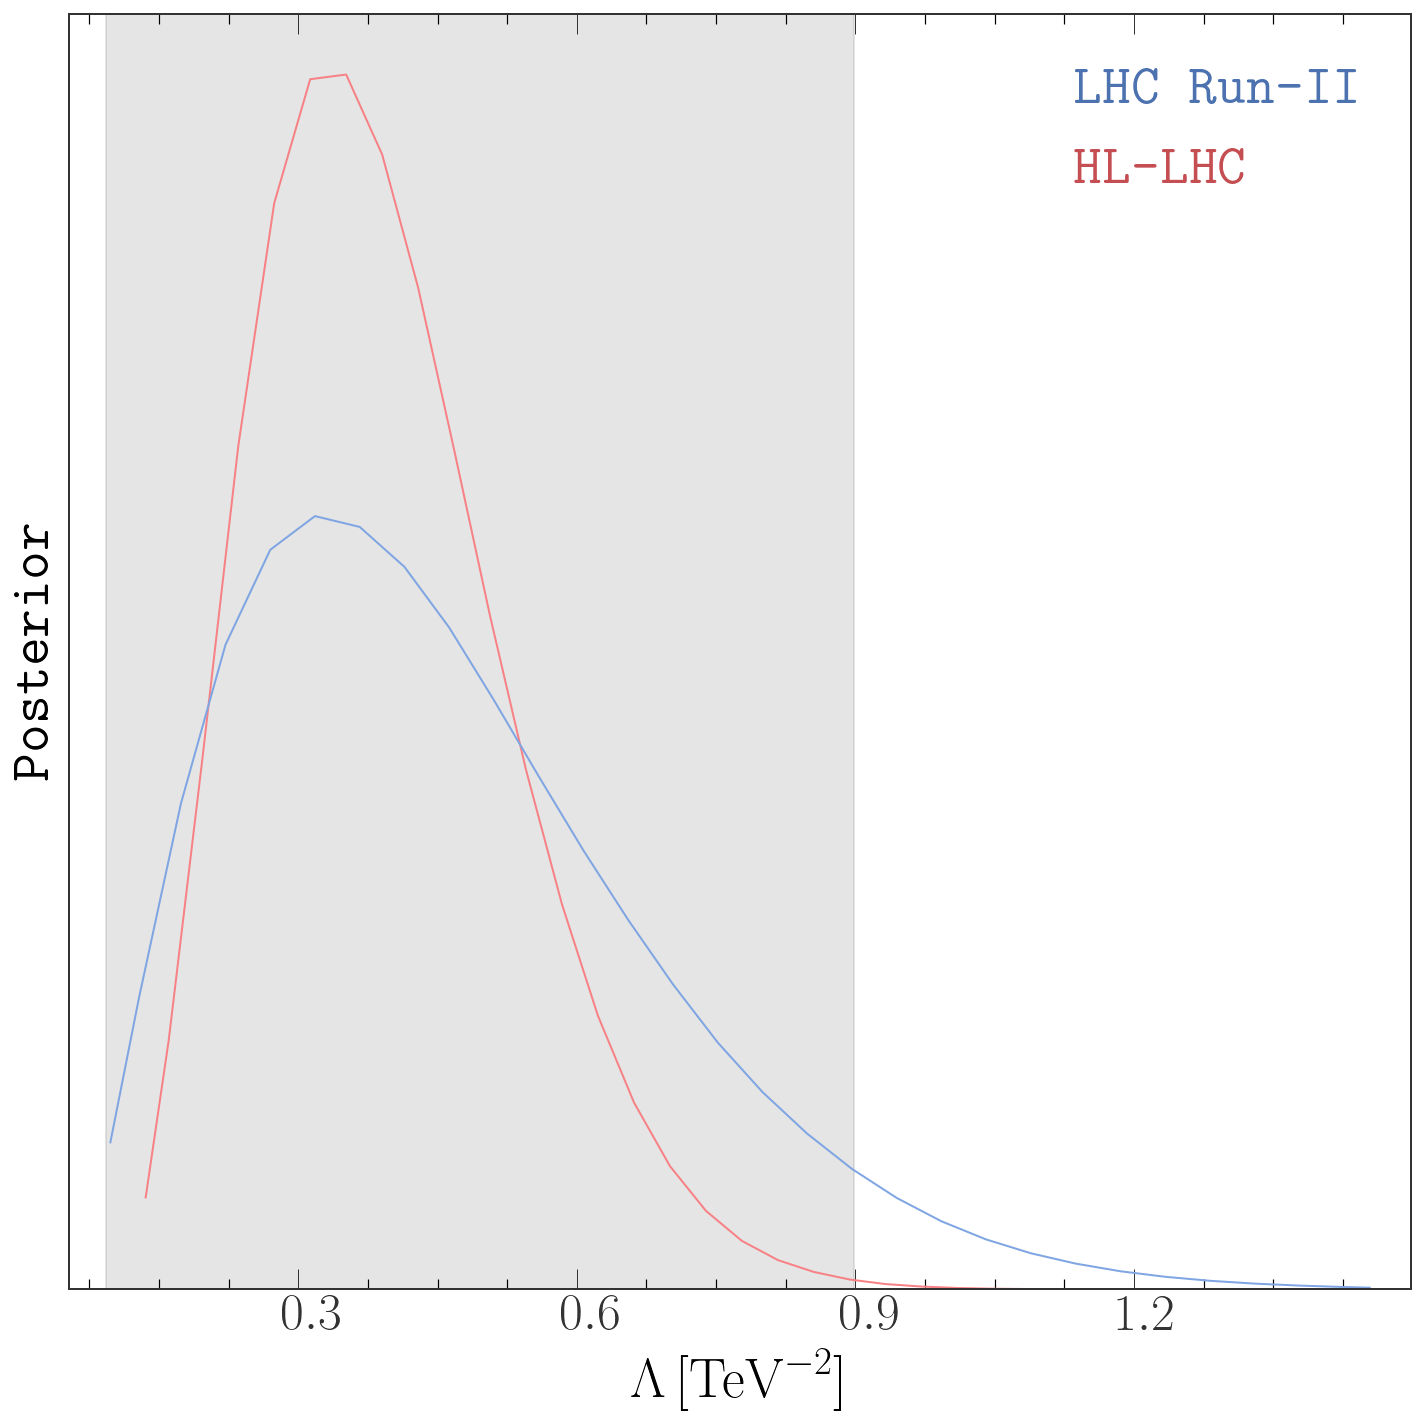

In [10]:
llCqtm =lambda c : mylikelihoodLambda(c,'Cqtqb1',1.0,data,collider='Run-II',l3mode='linear')
llCqtq =lambda c : mylikelihoodLambda(c,'Cqtqb1',1.0,data,collider='HL-LHC',l3mode='quadratic')
limits = [0.001, 1.5]
config = [50000, 0.8, 8]
trace_dir1=dirc+'/results/fits/Cqtqb1-scale_LHC_RunII_rge.pickle'
trace_dir2=dirc+'/results/fits/Cqtqb1-scale_HL-LHC_rge.pickle'
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config,trace_dir=trace_dir1)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config,trace_dir=trace_dir2)
df_cqtqb1=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqtqb1_scale.pdf','$\Lambda$' ,limits)
######
llCqtm =lambda c : mylikelihoodLambda(c,'Cqtqb8',1.0,data,collider='Run-II',l3mode='linear')
llCqtq =lambda c : mylikelihoodLambda(c,'Cqtqb8',1.0,data,collider='HL-LHC',l3mode='quadratic')
limits = [0.001, 1.5]
config = [50000, 0.8, 8]
trace_dir1=dirc+'/results/fits/Cqtqb8-scale_LHC_RunII_rge.pickle'
trace_dir2=dirc+'/results/fits/Cqtqb8-scale_HL-LHC_rge.pickle'
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config,trace_dir=trace_dir1)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config,trace_dir=trace_dir2)
df_cqtqb8=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqtqb8_scale.pdf','$\Lambda$' ,limits)

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 200
Interrupted at 199 [0%]: Average Loss = 17.238
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 5_000 tune and 25_000 draw iterations (40_000 + 200_000 draws total) took 43 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 3100
Interrupted at 3,099 [1%]: Average Loss = 7.8552
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 5_000 tune and 25_000 draw iterations (40_000 + 200_000 draws total) took 186 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
        mean        sd  hdi_2.275%  hdi_97.725%       b0        b1
k1  0.313015  0.142263     0.08605     0.605243  0.08605  0.605243
HL-LHC
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1  0.266557  0.070901    0.143199     0.413105  0.143199  0.413105


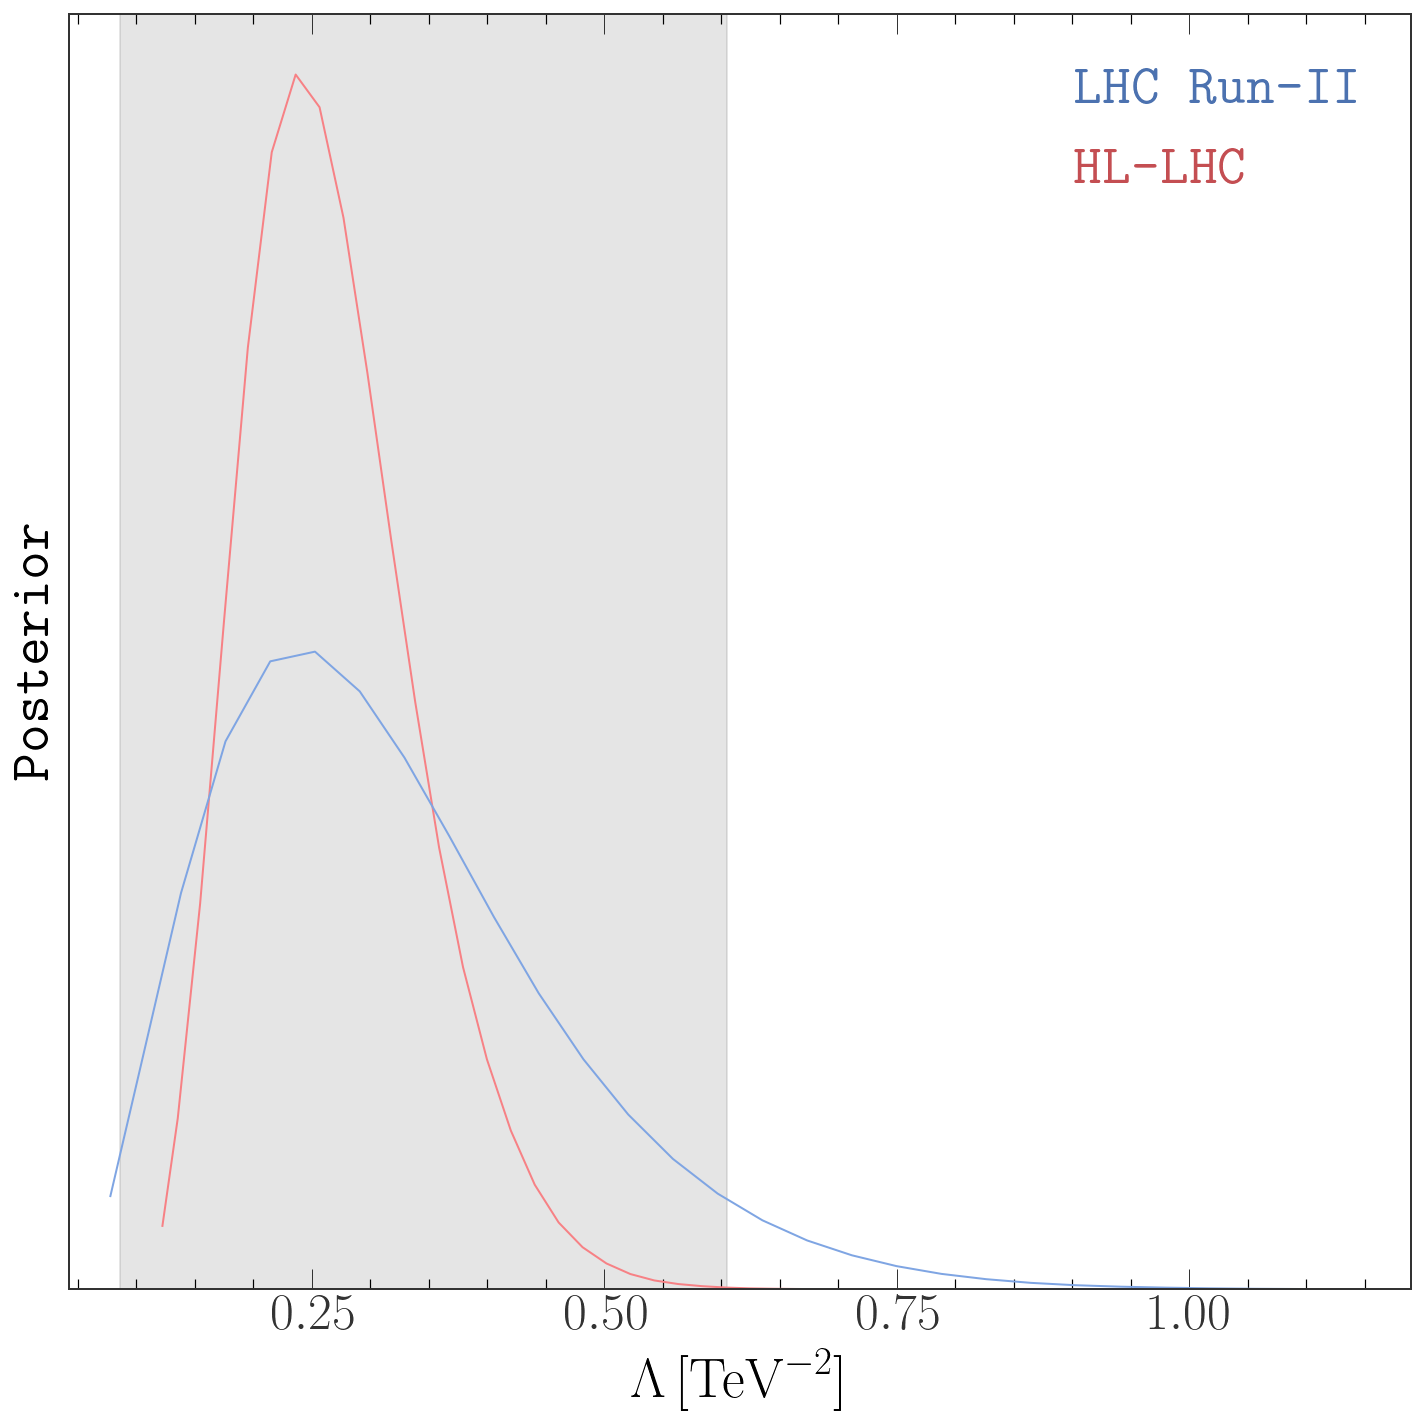

In [8]:
llCqtm =lambda c : mylikelihoodLambda(c,'Cqt1',1.0,data,collider='Run-II',l3mode='linear')
llCqtq =lambda c : mylikelihoodLambda(c,'Cqt1',1.0,data,collider='HL-LHC',l3mode='quadratic')
limits = [0.001, 1.5]
config = [25000, 0.8, 8]
trace_dir1=dirc+'/results/fits/Cqt1-scale_LHC_RunII_rge.pickle'
trace_dir2=dirc+'/results/fits/Cqt1-scale_HL-LHC_rge.pickle'
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config,trace_dir=trace_dir1)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config,trace_dir=trace_dir2)
df_cqt1=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqt1_scale.pdf','$\Lambda$' ,limits)

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 1400
Interrupted at 1,399 [0%]: Average Loss = 13.712
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 5_000 tune and 25_000 draw iterations (40_000 + 200_000 draws total) took 43 seconds.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 500
Interrupted at 499 [0%]: Average Loss = 1.4923
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [k1]


Sampling 8 chains for 5_000 tune and 25_000 draw iterations (40_000 + 200_000 draws total) took 187 seconds.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
There were 180 divergences after tuning. Increase `target_accept` or reparameterize.
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
There were 157 divergences after tuning. Increase `target_accept` or reparameterize.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
There were 169 divergences after tuning. Increase `target_accept` or reparameterize.
There were 188 divergences after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
        mean        sd  hdi_2.275%  hdi_97.725%        b0        b1
k1  0.810482  0.347405    0.232296     1.474204  0.232296  1.474204
HL-LHC
        mean        sd  hdi_2.275%  hdi_97.725%        b0       b1
k1  0.541299  0.229961    0.168742      1.00974  0.168742  1.00974


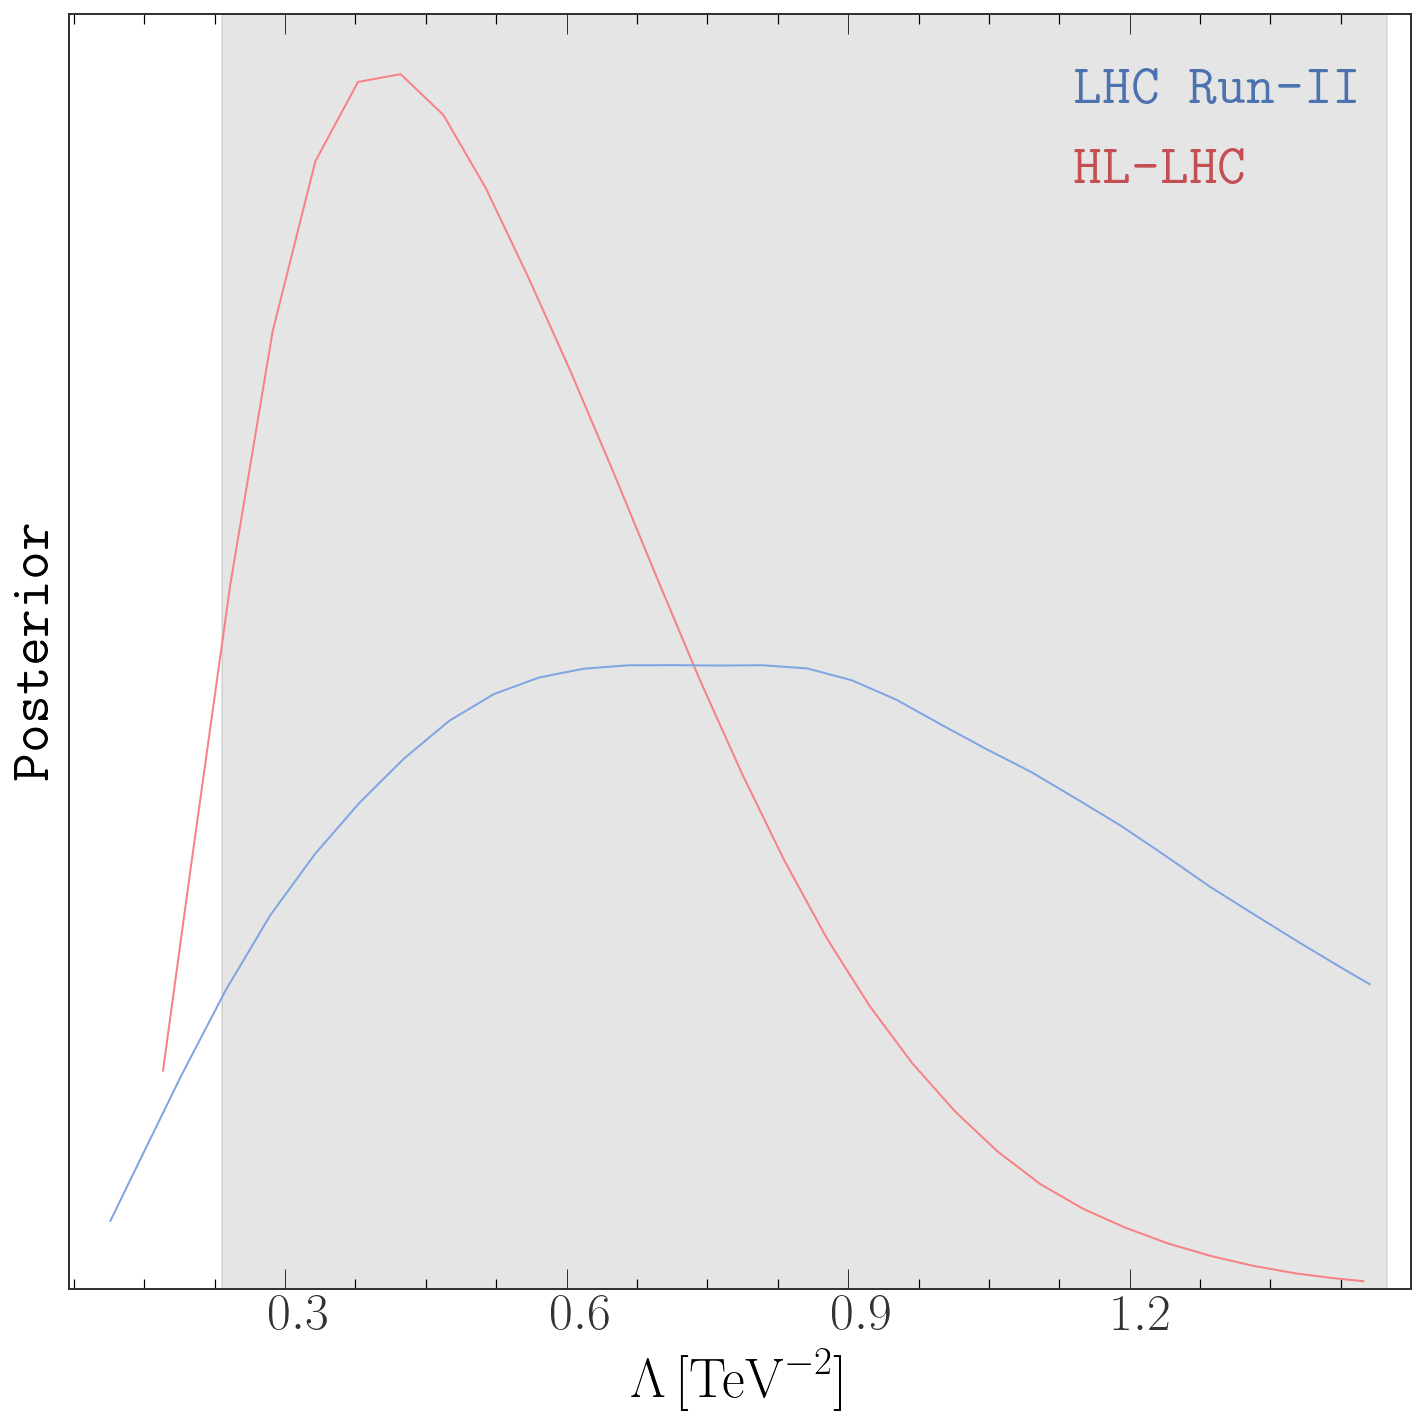

In [9]:
llCqtm =lambda c : mylikelihoodLambda(c,'Cqt8',1.0,data,collider='Run-II',l3mode='linear')
llCqtq =lambda c : mylikelihoodLambda(c,'Cqt8',1.0,data,collider='HL-LHC',l3mode='quadratic')
limits = [0.001, 2.5]
config = [25000, 0.8, 8]
trace_dir1=dirc+'/results/fits/Cqt8-scale_LHC_RunII_rge.pickle'
trace_dir2=dirc+'/results/fits/Cqt8-scale_HL-LHC_rge.pickle'
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config,trace_dir=trace_dir1)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config,trace_dir=trace_dir2)
df_cqt8=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqt8_scale.pdf','$\Lambda$' ,limits)

In [13]:
getrun2 = lambda xdf: 1/((xdf["up"]["run2"]-xdf["low"]["run2"])/2.)**0.5
gethl= lambda xdf: 1/((xdf["up"]["hl"]-xdf["low"]["hl"])/2.)**0.5
df = pd.DataFrame({"index":[0,1,2,3,4,5,6]
                   ,"wilson_coef":["cphiL","cphiQ","cphihh","cqt8","cqt1","cqtqb8","cqtqb1"]
                   ,"runtwo":[getrun2(df_cphi_linear),getrun2(df_cphi_quad),0.34,getrun2(df_cqt8),getrun2(df_cqt1),getrun2(df_cqtqb8),getrun2(df_cqtqb1)]
                   , "hightlum":[gethl(df_cphi_linear),gethl(df_cphi_quad),0.87,gethl(df_cqt8),gethl(df_cqt1),gethl(df_cqtqb8),gethl(df_cqtqb1)]
                  })
df.to_csv(r'../results/single_fit_HL-LHC14.csv')
df

,index,wilson_coef,runtwo,hightlum
0,0,cphiL,0.286739,0.401751
1,1,cphiQ,0.332640,0.390087
2,2,cphihh,0.340000,0.870000
3,3,cqt8,0.544459,0.847920
4,4,cqt1,1.227486,1.857186
5,5,cqtqb8,0.253380,0.350097
6,6,cqtqb1,0.567343,0.808296


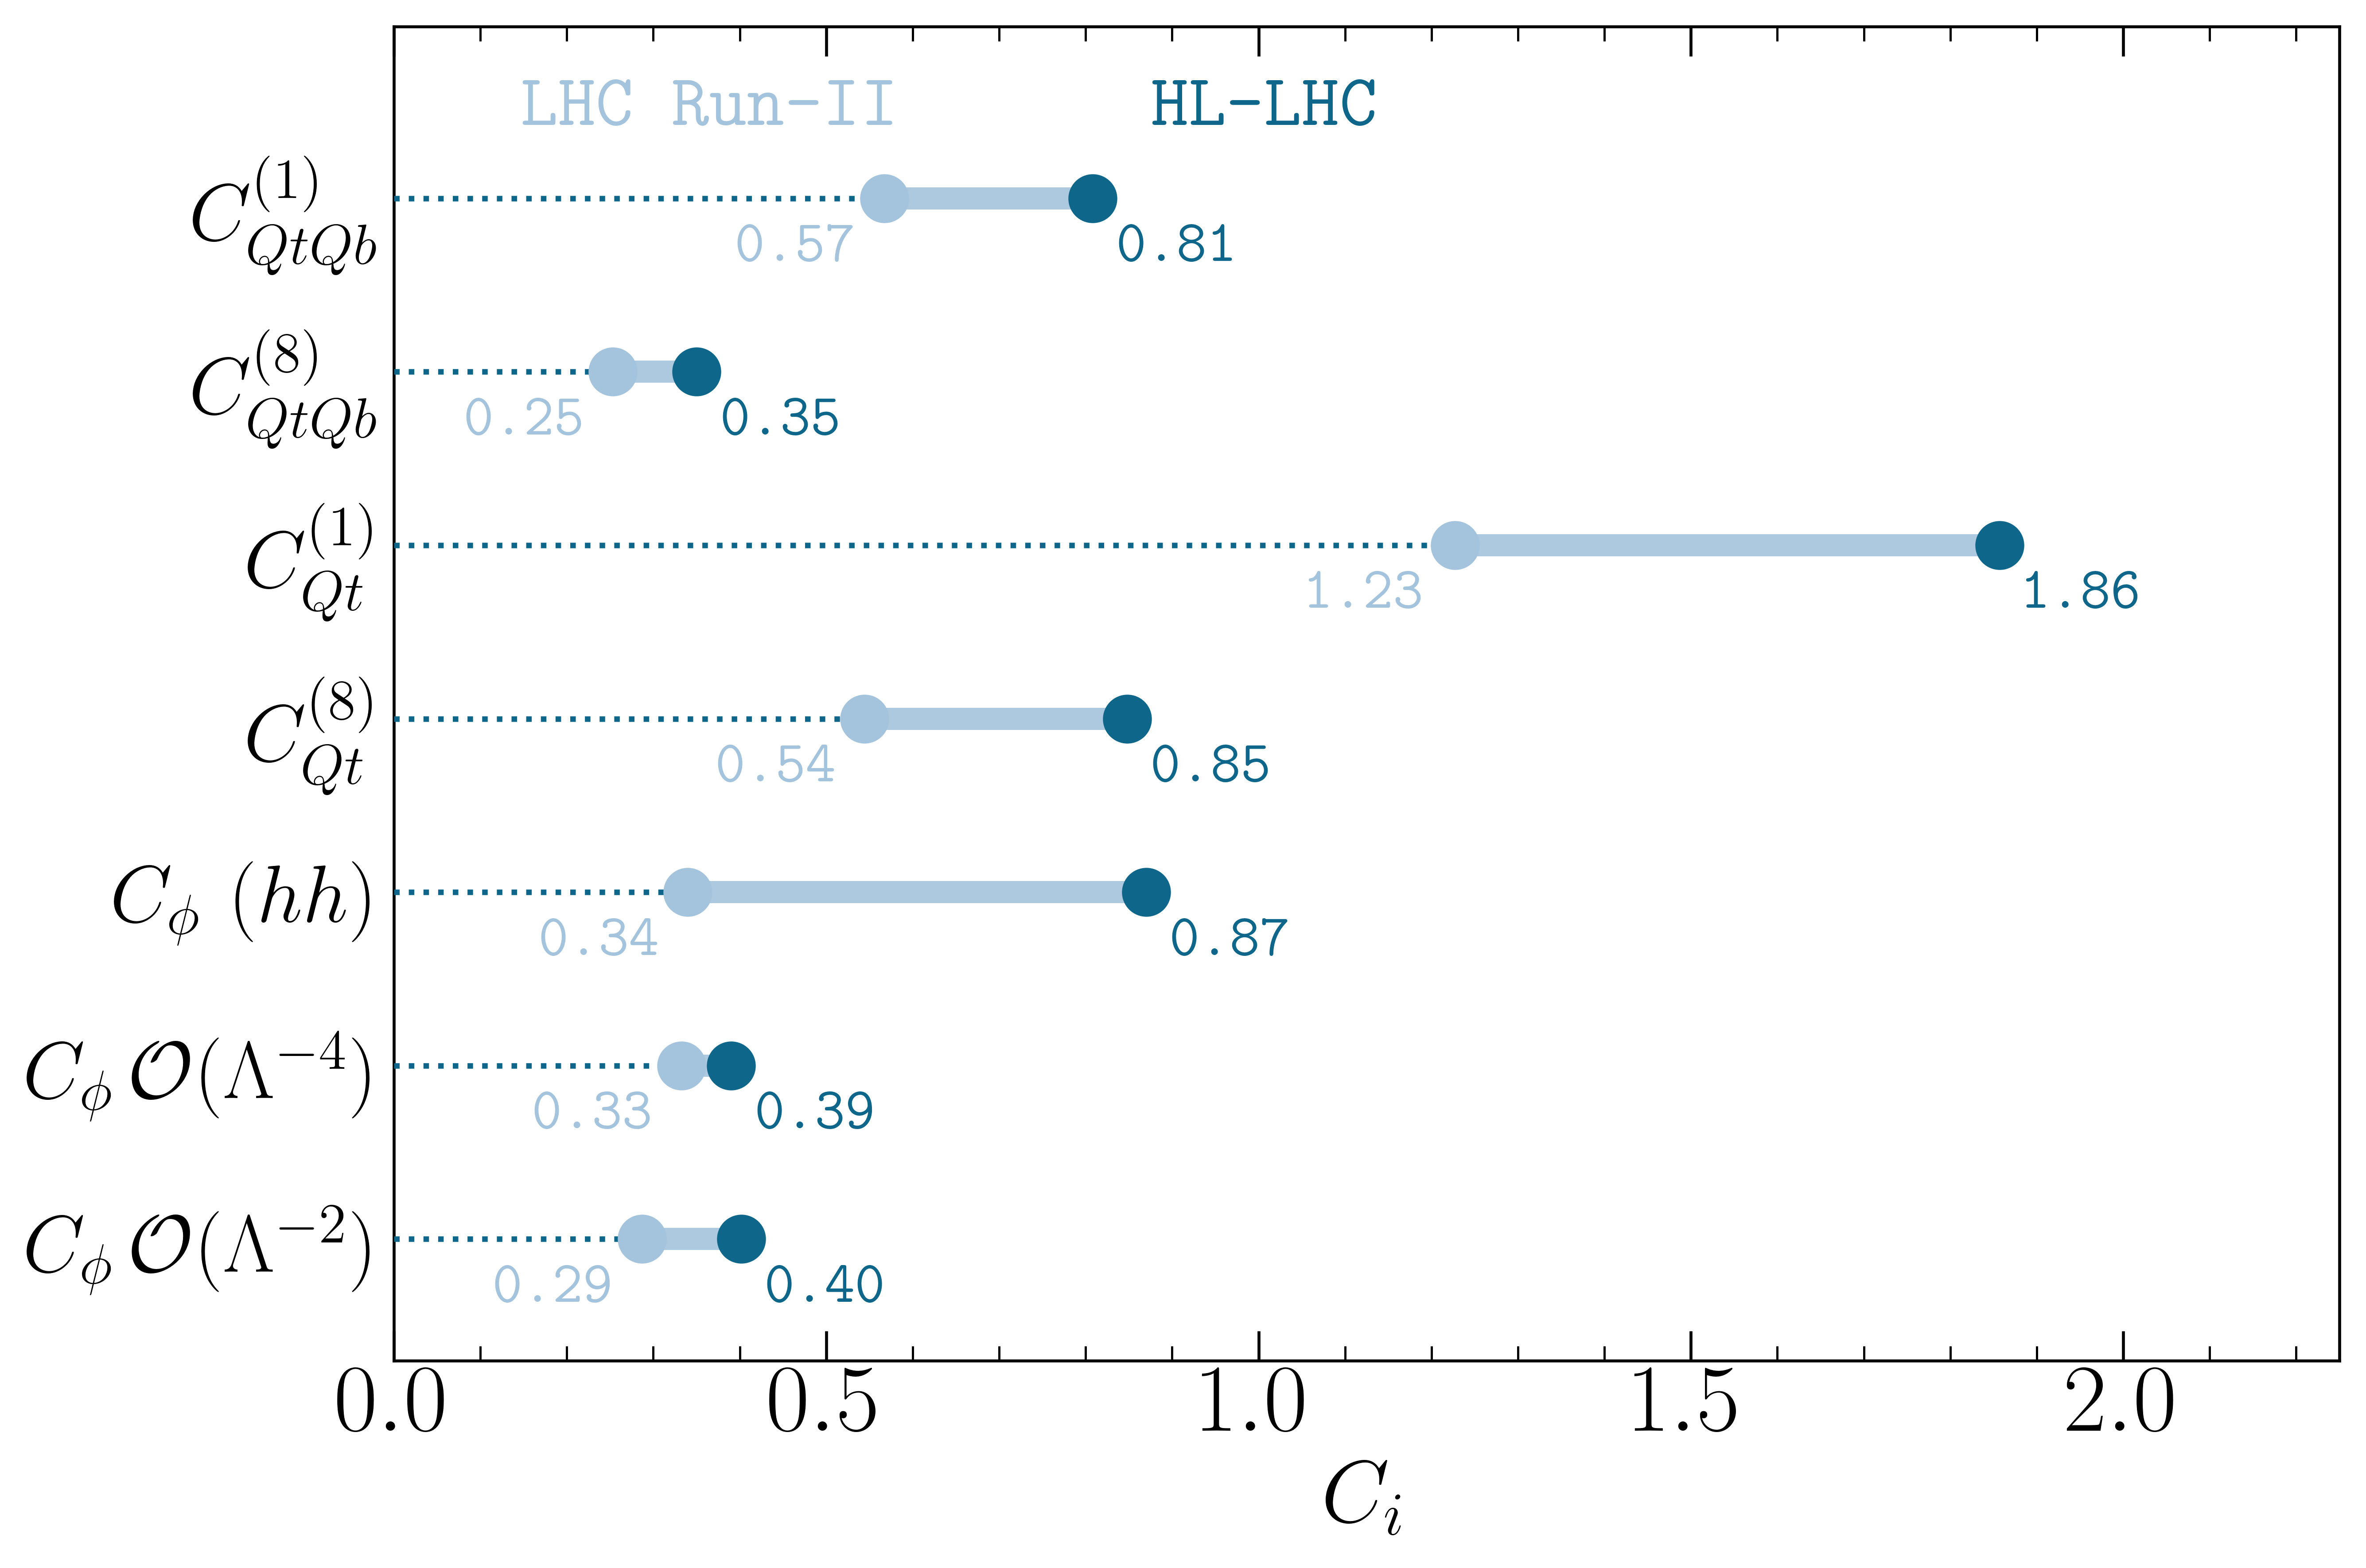

In [22]:
import matplotlib.lines as mlines
#
col1='#a3c4dc' # light
col2='#0e668b' # dark

#col1='#9dd4d7' # light
#col2='#006f71' # dark
# Import Data
df = pd.read_csv("../results/single_fit_HL-LHC14.csv")

# Func to draw line segment
def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], lw= 6,color=col1, alpha= 0.9)
    ax.add_line(l)
    return l

# Figure and Axes
fig, ax = plt.subplots(1,1,figsize=(9,6), dpi= 300)

# Vertical Lines
#ax.vlines(x=.05, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
#ax.vlines(x=.10, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
#ax.vlines(x=.15, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
#ax.vlines(x=.20, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')

# Points
ax.scatter(y=df['index'], x=df['runtwo'], s=150, color=col1, alpha=1,zorder=12)
for i, p1, p2 in zip(df['index'], df['runtwo'], df['hightlum']):
    newline([p1, i], [p2, i])
    plt.hlines(i,0.0,p1,color=col2, ls=':',zorder=10)
ax.scatter(y=df['index'], x=df['hightlum'], s=150, color=col2, alpha=1, zorder= 9)


for x, y, tex in zip(df['runtwo'], df['index'], df['runtwo']):
    if y==6:
        plt.text(x-0.2, y+0.5, r'LHC Run-II', horizontalalignment='center', 
                 verticalalignment='center', fontdict={'color':col1,'size':20})       
    t = plt.text(x-0.1, y-0.3,"{:1.2f}".format(tex), horizontalalignment='center', 
                 verticalalignment='center', fontdict={'color':col1,'size':16})

for x, y, tex in zip(df['hightlum'], df['index'], df['hightlum']):
    if y==6:
        plt.text(x+0.2, y+0.5, r'HL-LHC', horizontalalignment='center', 
                 verticalalignment='center', fontdict={'color':col2,'size':20})     
    t = plt.text(x+0.1, y-0.3, "{:1.2f}".format(tex), horizontalalignment='center', 
                 verticalalignment='center', fontdict={'color':col2,'size':16})
    
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off)
    size=4
         ) 
#ax.set_title("Dumbell Chart: Pct Change - 2013 vs 2014", fontdict={'size':22})
ax.get_xaxis().set_minor_locator(AutoMinorLocator())
ax.set_yticklabels(['',r'$C_{\phi}\,\mathcal{O}(\Lambda^{-2})$',r'$C_{\phi}\, \mathcal{O}(\Lambda^{-4})$',r'$C_{\phi}\,\,(hh)$',\
                   r'$C_{Qt}^{(8)}$',r'$C_{Qt}^{(1)}$',\
                   r'$C_{QtQb}^{(8)}$',r'$C_{QtQb}^{(1)}$'])
ax.set_xlabel(r"$\Lambda$ [TeV]", fontsize=24)
ax.set(ylim=(-0.7, 6.99), xlim=(-0.0,2.25))
#ax.set(ylim=(-0.7, 6.99), xlim=(-0.0,13))
#plt.text(2.25,2.5,r'Single param. fit', fontsize=20)
#plt.text(2.5,2,r'$95\%$ CI', fontsize=20)
plt.tight_layout()
#plt.gca().invert_yaxis()

plt.savefig('../results/plots/HL-LHC_reachWC.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [10]:
run2 =np.array([ (+0.919+25.28)/2.0 , (1.422+16.5684)/2,(0.22+1.06)/2.,(6.65+1.159)/2.,(0.199+0.031)/2.])
np.log10(run2)

array([ 1.11725472,  0.95401082, -0.19382003,  0.59156543, -0.93930216])

[3.11725472 2.95401082 1.80617997 2.59156543 1.06069784 1.90194847
 3.515946   3.88860908 3.54950597]
[2.7863716  2.81693694 1.45331834 2.22310638 0.98677173 1.69178852
 3.2824737  3.4530889  3.54828498]


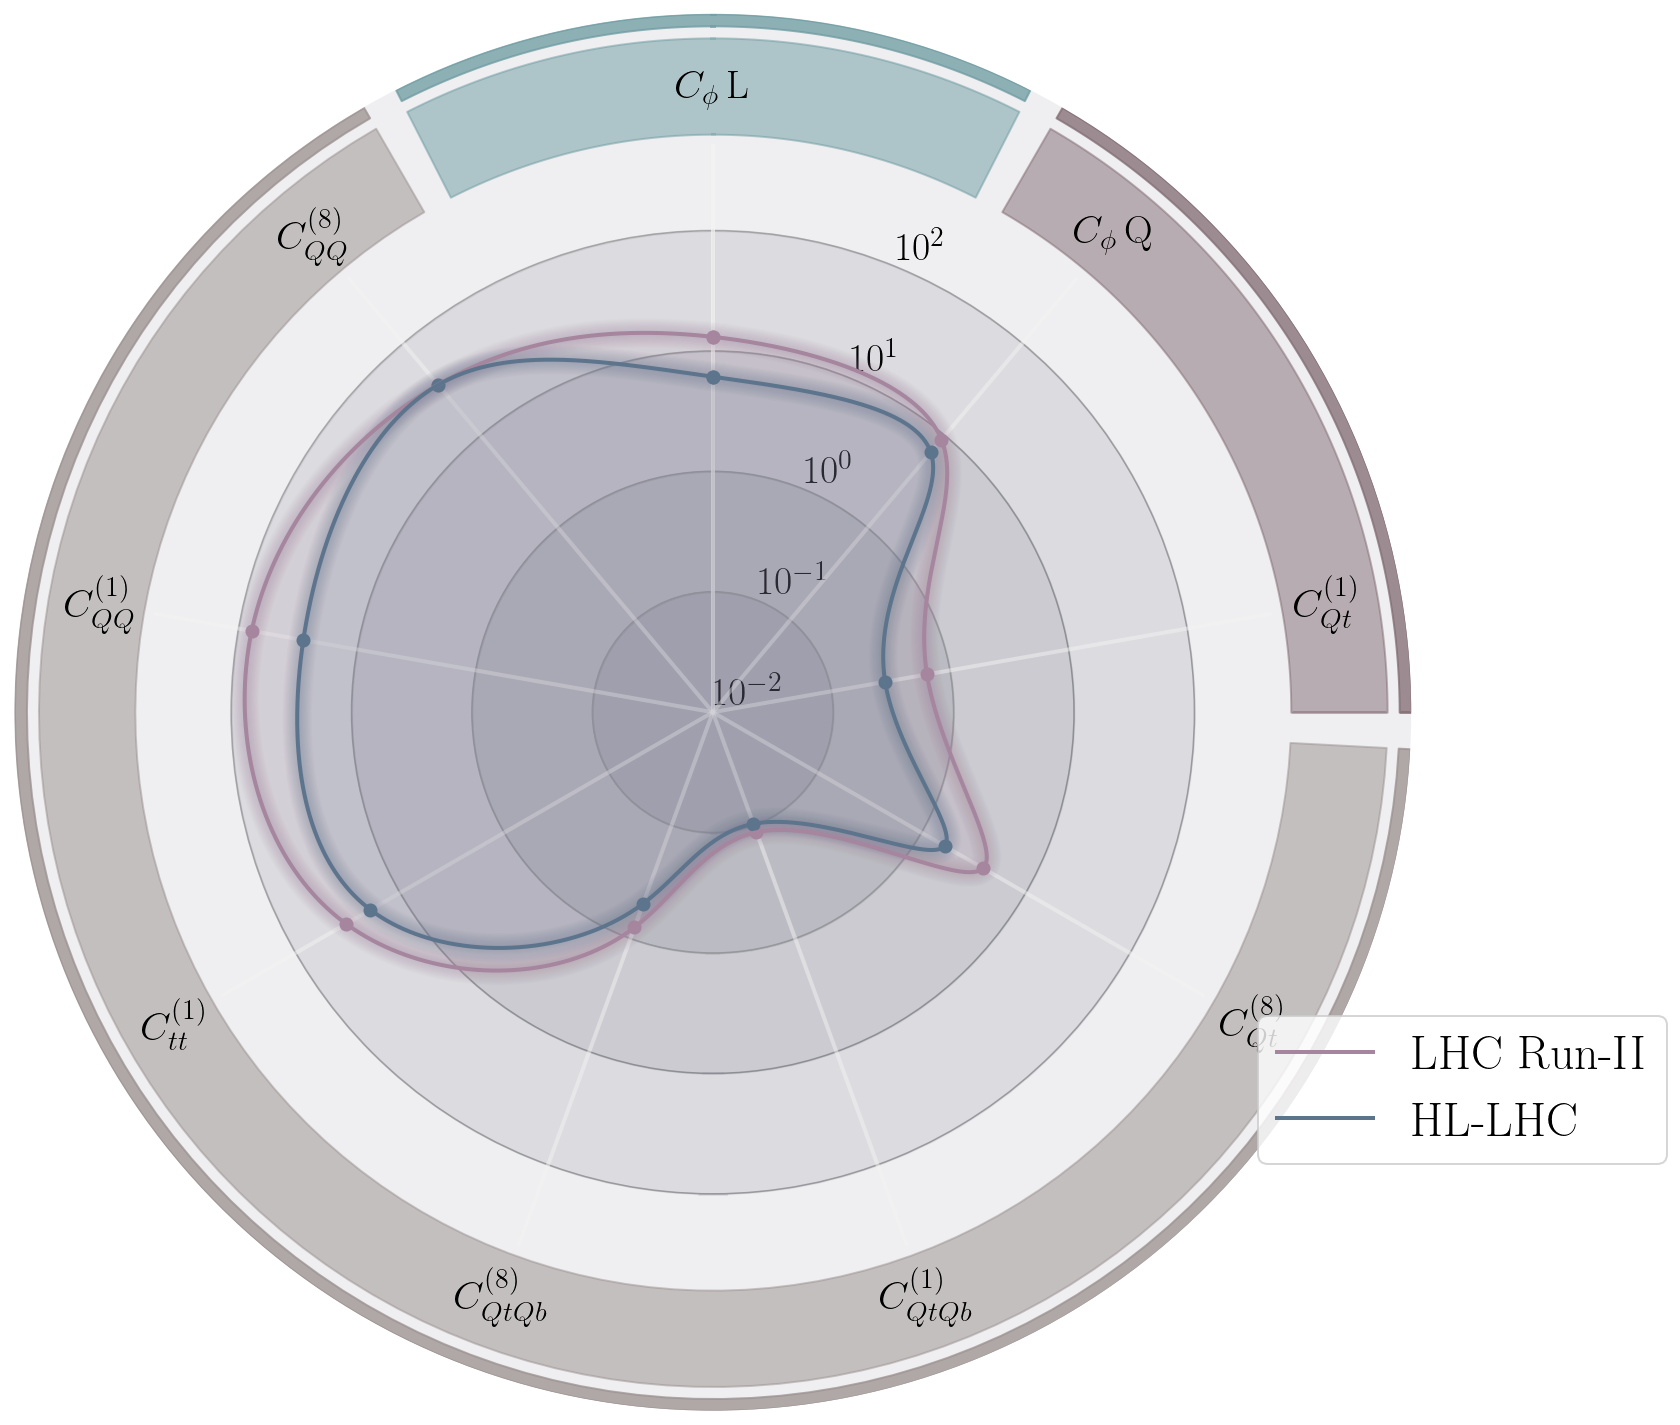

In [3]:

run2 =np.array([ (+0.919+25.28)/2.0 , (1.422+16.5684)/2,(0.22+1.06)/2.,(6.65+1.159)/2.,(0.199+0.031)/2.,
                (1.3428+0.253)/2.,(58.051+7.5599)/2,(133.013+21.74)/2,( 89.28+-18.398)/2 ])
hl=np.array([(6.0423+6.187)/2.0,(5.189+7.932)/2.0, (0.278+0.290)/2.,(1.70+1.643)/2,(0.097+0.097)/2., 
             (0.4846+0.4990)/2.,(18.6169+19.71)/2 ,(28.18+28.59)/2, (35.588+35.095)/2] )

run2=2+np.log10(run2)
print(run2)
hl=2+np.log10(hl)
print(hl)
labs=[r'$C_{\phi}\,\mathrm{L}$',r'$C_{\phi}\,\mathrm{Q}$',\
                   r'$C_{Qt}^{(1)}$',r'$C_{Qt}^{(8)}$',\
                   r'$C_{QtQb}^{(1)}$',r'$C_{QtQb}^{(8)}$',r'$C_{tt}^{(1)}$'\
      , r'$C_{QQ}^{(1)}$',r'$C_{QQ}^{(8)}$'
     ]
plt.figure(figsize=(14,10))
plt.rcParams["axes.axisbelow"] = False
ax = plt.subplot(polar=True)
plt.rcParams['xtick.labelsize'] = 24
ax =FancySpiderPlot(ax,data=[run2,hl],
                    yticks=[0,1,2,3,4],
                    ytickslabels=[r"$10^{-2}$",r"$10^{-1}$",r"$10^{0}$",r"$10^{1}$",r"$10^{2}$"],
                    ylim=(0,5.8),
                   # facecolor=('#e5e6dd','#dbdcda'),
                    colors=['#a6859e','#5d748d'],
                    DataLabels=[r"LHC Run-II",r"HL-LHC"],
                    XaxisLabels=labs,
                    XaxisPad=-45)
######################
##decor 
#####################
ax.fill_between(
    np.linspace(-27/180*np.pi, +27/180*np.pi, 100),
    5.7,
    5.8,
    alpha=0.75,
    color='#6d9ba1', zorder= -4
)
ax.fill_between(
    np.linspace(-27/180*np.pi, +27/180*np.pi, 100), 
    4.8,
    5.6,
    alpha=0.5,
    color='#6d9ba1', zorder= -4
)
ax.fill_between(
    np.linspace(30/180*np.pi, +90/180*np.pi, 100), 
    5.7,
    5.8,
    alpha=0.75,
    color='#816b72', zorder= -4
)
ax.fill_between(
    np.linspace(30/180*np.pi, +90/180*np.pi, 100), 
    4.8,
    5.6,
    alpha=0.5,
    color='#816b72', zorder= -4
)
ax.fill_between(
    np.linspace(93/180*np.pi, +330/180*np.pi, 100), 
    5.7,
    5.8,
    alpha=0.75,
    color='#9a908f', zorder= -4
)
ax.fill_between(
    np.linspace(93/180*np.pi, +330/180*np.pi, 100), 
    4.8,
    5.6,
    alpha=0.5,
    color='#9a908f', zorder= -4
)

##########################
ax.legend(bbox_to_anchor=(1.2, 0.3),fontsize=24)
plt.tight_layout()
plt.show()

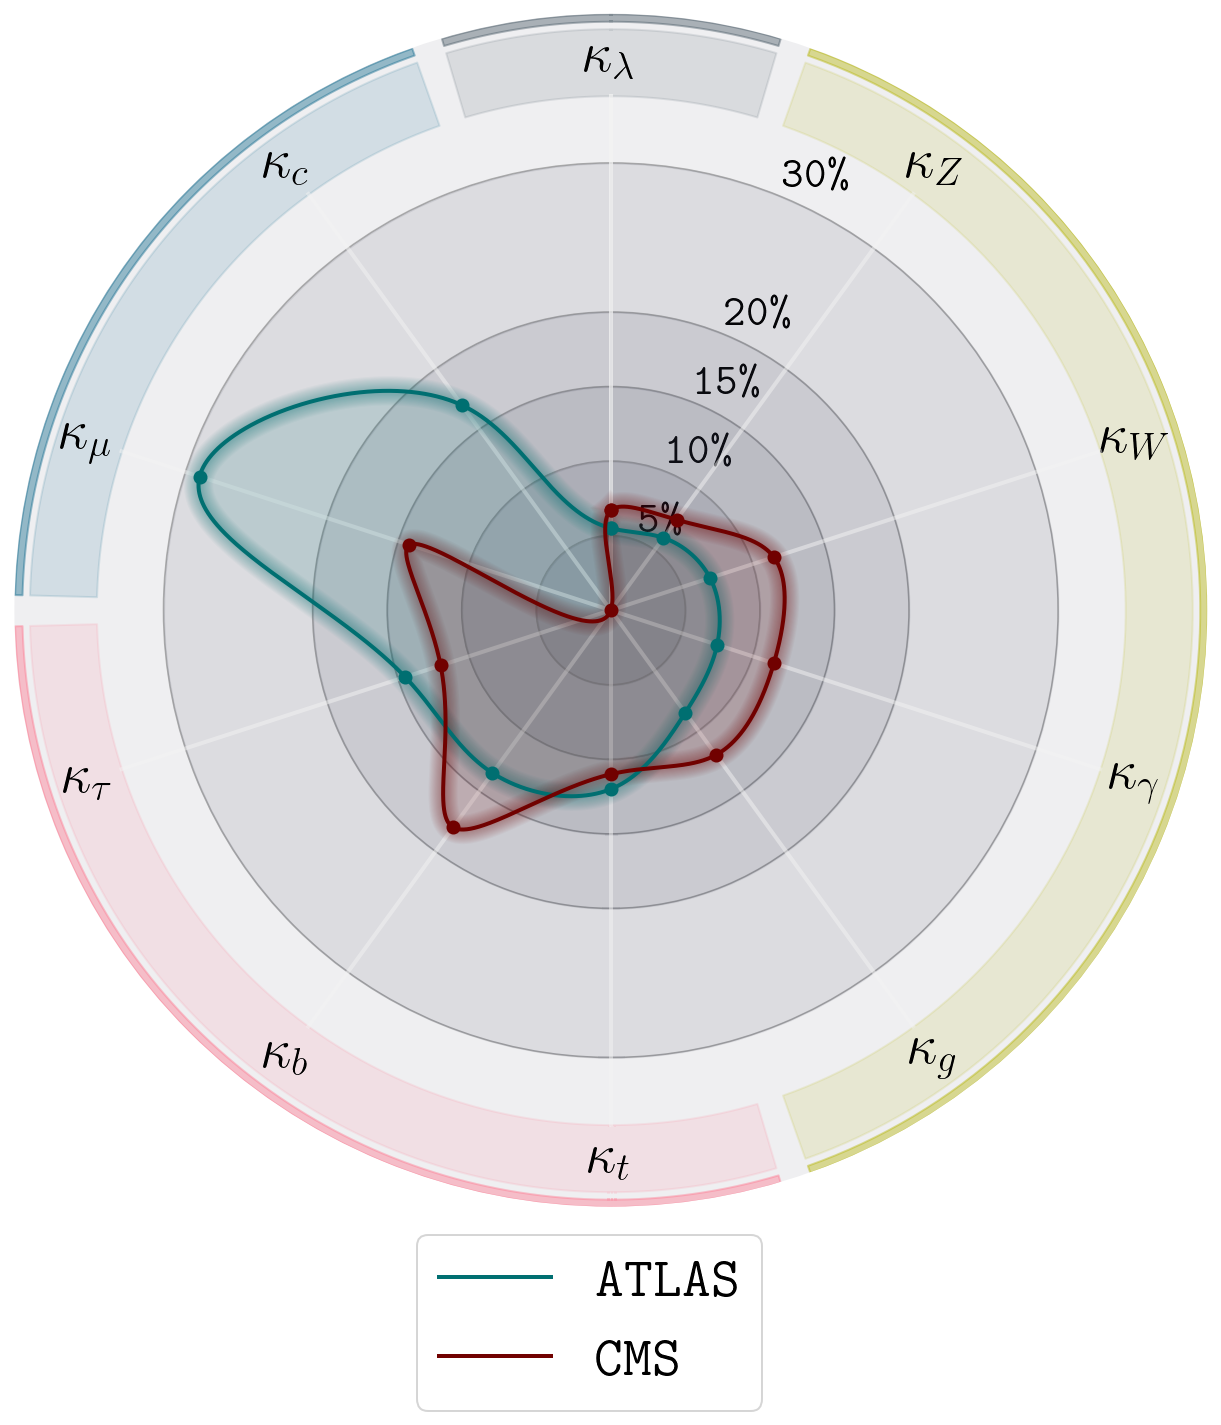

In [35]:
plt.rcParams['xtick.labelsize'] = 28
labs=[r'$\kappa_\lambda$',r'$\kappa_Z$',r'$\kappa_W$',
      r'$\kappa_\gamma$',r'$\kappa_g$',r'$\kappa_t$',
      r'$\kappa_b$',r'$\kappa_\tau$',r'$\kappa_\mu$',
      r'$\kappa_c$'\
     ]
ATLAS =np.array(
        [
      .055, #100
       .06,.07, .075, .085, .12,.135,.145,.29,.17 #*5
    ]
)


CMS =np.array(
    [
    .067,#100
      .075,.115,.115,.12,.11,.18,.12,.142, #*5
     0.0
    ]
)
plt.figure(figsize=(14,10))
plt.rcParams["axes.axisbelow"] = False
ax = plt.subplot(polar=True)
plt.rcParams['xtick.labelsize'] = 24
ax =FancySpiderPlot(ax,data=[ATLAS*100,CMS*100],
                    yticks=[0,5,10,15,20,30],
                    ytickslabels=[r"",r"5\%",r"10\%",r"15\%",r"20\%",r"30\%"],
                    ylim=(0,40),
                   # facecolor=('#e5e6dd','#dbdcda'),
                    #colors=['#a6859e','#5d748d'],
                    DataLabels=[r"ATLAS",r"CMS"],
                    XaxisLabels=labs,
                    XaxisPad=-30,
                   gridpad=5.5)
######################
##decor 
#####################
a= 36/2
d= (1.5)/180*np.pi
ax.fill_between(
    np.linspace(-a/180*np.pi+d, +a/180*np.pi-d, 100),
    39.5,
    40,
    alpha=0.4,
    color='#40525e', zorder= -4
)
ax.fill_between(
    np.linspace(-a/180*np.pi+d, +a/180*np.pi-d, 100),
    34.5,
    39.,
    alpha=0.125,
    color='#40525e', zorder= -4
)
######
ax.fill_between(
    np.linspace(a/180*np.pi+d, +9*a/180*np.pi-d, 100),
    39.5,
    40,
    alpha=0.4,
    color='#b3b300', zorder= -4
)
ax.fill_between(
    np.linspace(a/180*np.pi+d, +9*a/180*np.pi-d, 100),
    34.5,
    39.,
    alpha=0.125,
    color='#b3b300', zorder= -4
)
######
ax.fill_between(
    np.linspace(9*a/180*np.pi+d, +15*a/180*np.pi-d, 100),
    39.5,
    40,
    alpha=0.4,
    color='#ff748c', zorder= -4
)
ax.fill_between(
    np.linspace(9*a/180*np.pi+d, +15*a/180*np.pi-d, 100),
    34.5,
    39.,
    alpha=0.125,
    color='#ff748c', zorder= -4
)
######
ax.fill_between(
    np.linspace(15*a/180*np.pi+d, 19*a/180*np.pi-d, 100),
    39.5,
    40,
    alpha=0.4,
    color='#0a668a', zorder= -4
)
ax.fill_between(
    np.linspace(15*a/180*np.pi+d, 19*a/180*np.pi-d, 100),
    34.5,
    39.,
    alpha=0.125,
    color='#0a668a', zorder= -4
)
##########################
ax.legend(bbox_to_anchor=(.65, 0.),fontsize=28)
plt.tight_layout()
plt.savefig('./Higgs_couplings_poster.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()